# Informations

## One script = one condition to make it easier to follow and correct.

### I am working in local for this analysis

### This script starts by taking the variant counts csv files and concatenate them together in a long df with all the reads and other informations. 

### After, with the long dataframe containing all reads for all variants it does some quality control. Then it calculates the selection coefficient. The last steps are the heatmaps and variants categorization.

#### The goal of the script is to be a linear analysis where it's easy to find information back, so it's not made to make tests. If something is wrong at any quality control step, go in another notebook to find the problem. I open other notebooks for most quality control and if there are a lot of figures to make or other things to verify.

### 1- Wide to long dataframe
### 2- Lanes control
### 3- Selection coefficient
### 4- Replicates control
### 5- Codons control
### 6- Overlaps control
### 7- Heatmaps and figures
### 8- t-tests

#### I save the dataframes along the way to be able to use them elsewhere. Dataframes and figures are saved automatically with the information given at the beginning (date+experiment).

In [2]:
##Import packages needed (and some not needed....)

import Bio

import openpyxl
from Bio import SeqIO
import os,sys,re

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)

import seaborn as sns
print(sns.__name__, sns.__version__)

from collections import Counter

import scipy as sp
import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel

pandas 1.5.2
numpy 1.23.5
matplotlib 3.4.1
scipy 1.10.0
seaborn 0.12.2


In [3]:
# Set up
# Here we can find all informations needed to run the script without changing code along the way. It limits errors.

##Condition

condition = "Voriconazole" #complete name
cond = "Vorico" #abbreviation useed in the dataframes

##date + experiment

date = "2023-12-06" #date of this analysis
date_info = "2023-06-20" #date on the reads information files
year = "2023" #year on the reads count files

experiment = "NovaSeq_winter2023_albicans"

## lists

cancel_list = [92,228, 232,233,234] #positions that did not work for any reasons

stop_list = [55,89,119,139,197,238,307,370,408,466,506] #list of stop codons in the library

#positions lists

f1_f2_over = [154,155,158,162]
f2_f3_over = [276,277,280] #275 was supposed to be there, but it's cut because of the primer
f3_f4_over = [401,402,403,404,405,406] #407 was supposed to be there, but it's cut because of the primer

over_list = [154,155,158,162,276,277,280,401,402,403,404,405,406] #all overlap

#codons

Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

DNA_Codons = {"GCT": "A", "GCC": "A", "GCA": "A", "GCG": "A","TGT": "C", "TGC": "C",
    "GAT": "D", "GAC": "D","GAA": "E", "GAG": "E","TTT": "F", "TTC": "F",
    "GGT": "G", "GGC": "G", "GGA": "G", "GGG": "G","CAT": "H", "CAC": "H","ATA": "I", "ATT": "I", "ATC": "I",
    "AAA": "K", "AAG": "K", "TTA": "L", "TTG": "L", "CTT": "L", "CTC": "L", "CTA": "L", "CTG": "L",
    "ATG": "M","AAT": "N", "AAC": "N","CCT": "P", "CCC": "P", "CCA": "P", "CCG": "P","CAA": "Q", "CAG": "Q",
    "CGT": "R", "CGC": "R", "CGA": "R", "CGG": "R", "AGA": "R", "AGG": "R","TCT": "S", "TCC": "S", "TCA": "S", 
    "TCG": "S", "AGT": "S", "AGC": "S","ACT": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "GTT": "V", "GTC": "V", "GTA": "V", "GTG": "V","TGG": "W","TAT": "Y", "TAC": "Y","TAA": "*", "TAG": "*", "TGA": "*"}

In [4]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

# 1- Wide to long dataframe

In [5]:
##taked all variant counts csv files to have a long df

##sorry this is the most horrible function I ever made (but somehow it works)

def wide_to_long(path_vari, path_info):
    
    df_info = pd.read_excel(path_info, header=0)
    df_info = df_info.sort_values(by='Name', ignore_index=True)
    
    files = [os.path.join(path_vari, i) for i in os.listdir(path_vari) if os.path.isfile(os.path.join(path_vari, i))]
    
    name_list = []
    
    # Get a list of the files names
    for name in files:
        file_name = os.path.splitext(os.path.basename(name))[0]
        name_list.append(file_name)
    
    dict_df = {}
    
    # For every file in the folder, read it and append to an empty dict
    for i in range(len(files)):
        print(str(files[i]))
        df = pd.read_csv(files[i], index_col=0)
        dict_df[name_list[i]] = df
        
    dict_melt = {}
    
    # Variants df wide to long
    for key in dict_df:
        df_reads = dict_df[key]
        dfm = df_reads.melt(ignore_index=False).reset_index()
        dfm = dfm.rename(columns={"index": "codon", "variable": "position", "value": "nbr_reads"})
        dict_melt[key] = dfm
        
    dict_df_long = {}
    inter = 0
    
    # Add the info in the long df
    for key in dict_melt:
        info = df_info

        times = len(dict_melt[key])
        con = info.iloc[inter, 3]
        tp = info.iloc[inter, 5]
        ant = info.iloc[inter, 6]
        frag = info.iloc[inter, 7]
        rep = info.iloc[inter, 8]
        la = info.iloc[inter, 9]
        OD = info.iloc[inter, 10]
        want = info.iloc[inter, 11]
        beef = info.iloc[inter, 12]
        afme = info.iloc[inter, 14]
        single = info.iloc[inter, 19]
        align = info.iloc[inter, 21]
        wt = info.iloc[inter, 22]

        chunk = pd.DataFrame({'Condition': [con], 'Timepoint': [tp], "Antifungal": [ant], "Fragment": [frag],
                              "Replicate": [rep], "Lane": [la], "OD": [OD], "reads_wanted": [want], "reads_before": [beef],
                              "reads_after_merge": [afme], "nbr_reads_single": [single], "reads_align": [align],
                              "reads_wt": [wt]})

        lala = chunk.loc[chunk.index.repeat(times)]
        lolilol = lala.reset_index()

        yay = pd.concat([dict_melt[key], lolilol], axis=1)
        print(yay)
        dict_df_long[key] = yay

        inter += 1
        
    df_list = list(dict_df_long.values())
    df_big = {}

    # Concatenate everybody together
    for i in range(len(df_list)):

        if i == 0:

            s1 = df_list[i]
            s2 = df_list[i + 1]
            df_big = pd.concat([s1, s2])
        
        elif i < len(df_list) and i != 0 and not i >= len(df_list) - 1:

            s1 = df_list[i + 1]
            df_big = pd.concat([df_big, s1], axis=0, ignore_index=True)
        
        else:
            print("The end")
        
    return df_big

In [6]:
F4_long = wide_to_long('../Variants Count/Fragment 4/',f"../Reads_info/Reads_count_CaERG11-F4_all.xlsx")
F3_long = wide_to_long('../Variants Count/Fragment 3/',f"../Reads_info/Reads_count_CaERG11-F3_all.xlsx")
F2_long = wide_to_long('../Variants Count/Fragment 2/',f"../Reads_info/Reads_count_CaERG11-F2_all.xlsx")
F1_long = wide_to_long('../Variants Count/Fragment 1/',f"../Reads_info/Reads_count_CaERG11-F1_all.xlsx")

F1_2_long = pd.concat([F1_long,F2_long],axis=0)
F3_4_long = pd.concat([F3_long, F4_long],axis=0)
All_long = pd.concat([F1_2_long, F3_4_long],axis=0)

All_long.to_csv(f'Long_df_variants_reads_final_{date}.csv')  

All_long

../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Clotri_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_1_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_2_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Fluco_F4_3_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Isa_F4_C_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_A_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_B_2023-06-20.csv
../Variants Count/Fragment 4/Variants_count_mut_CaERG11_0_Itra_F4_C_2023-06-20.cs

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      401      959.0      0  CaERG11_0_Vorico_F4_C          0   
1      GCC      401      500.0      0  CaERG11_0_Vorico_F4_C          0   
2      TGC      401      734.0      0  CaERG11_0_Vorico_F4_C          0   
3      TGT      401     1214.0      0  CaERG11_0_Vorico_F4_C          0   
4      GAT      401      394.0      0  CaERG11_0_Vorico_F4_C          0   
...    ...      ...        ...    ...                    ...        ...   
2062   GTC      511      509.0      0  CaERG11_0_Vorico_F4_C          0   
2063   TGG      511      715.0      0  CaERG11_0_Vorico_F4_C          0   
2064   TAC      511      862.0      0  CaERG11_0_Vorico_F4_C          0   
2065   TAT      511      526.0      0  CaERG11_0_Vorico_F4_C          0   
2066   TAA      511        8.0      0  CaERG11_0_Vorico_F4_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0        Vorico       

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      401      703.0      0  CaERG11_3_None_F4_2          3   
1      GCC      401      418.0      0  CaERG11_3_None_F4_2          3   
2      TGC      401      481.0      0  CaERG11_3_None_F4_2          3   
3      TGT      401      609.0      0  CaERG11_3_None_F4_2          3   
4      GAT      401      245.0      0  CaERG11_3_None_F4_2          3   
...    ...      ...        ...    ...                  ...        ...   
2062   GTC      511      381.0      0  CaERG11_3_None_F4_2          3   
2063   TGG      511      449.0      0  CaERG11_3_None_F4_2          3   
2064   TAC      511      466.0      0  CaERG11_3_None_F4_2          3   
2065   TAT      511      278.0      0  CaERG11_3_None_F4_2          3   
2066   TAA      511        NaN      0  CaERG11_3_None_F4_2          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F4          2  L001  8.224195   

The end
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Clotri_F3_C_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_1_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_2_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L001_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Fluco_F3_3_L002_2023-03-10.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_A_2023-06-20.csv
../Variants Count/Fragment 3/Variants_count_mut_CaERG11_0_Isa_F3_B_2023-06-20.csv
../Variants Count/Fragment 3/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      440.0      0  CaERG11_0_None_F3_1          0   
1      GCC      276      528.0      0  CaERG11_0_None_F3_1          0   
2      TGC      276      564.0      0  CaERG11_0_None_F3_1          0   
3      TGT      276      321.0      0  CaERG11_0_None_F3_1          0   
4      GAT      276      347.0      0  CaERG11_0_None_F3_1          0   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      524.0      0  CaERG11_0_None_F3_1          0   
2102   TGG      406      420.0      0  CaERG11_0_None_F3_1          0   
2103   TAC      406      906.0      0  CaERG11_0_None_F3_1          0   
2104   TAT      406      410.0      0  CaERG11_0_None_F3_1          0   
2105   TAA      406        1.0      0  CaERG11_0_None_F3_1          0   

     Antifungal Fragment  Replicate  Lane    OD  reads_wanted  reads_before  \
0          None       F3          1  L002  7

     codon position  nbr_reads  index           Condition  Timepoint  \
0      GCT      276       61.0      0  CaERG11_2_Isa_F3_A          2   
1      GCC      276       89.0      0  CaERG11_2_Isa_F3_A          2   
2      TGC      276       84.0      0  CaERG11_2_Isa_F3_A          2   
3      TGT      276       56.0      0  CaERG11_2_Isa_F3_A          2   
4      GAT      276     1496.0      0  CaERG11_2_Isa_F3_A          2   
...    ...      ...        ...    ...                 ...        ...   
2101   GTC      406      569.0      0  CaERG11_2_Isa_F3_A          2   
2102   TGG      406       58.0      0  CaERG11_2_Isa_F3_A          2   
2103   TAC      406      833.0      0  CaERG11_2_Isa_F3_A          2   
2104   TAT      406      389.0      0  CaERG11_2_Isa_F3_A          2   
2105   TAA      406        2.0      0  CaERG11_2_Isa_F3_A          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0           Isa       F3         A  L001  10.77653       5000000   

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      276      442.0      0  CaERG11_3_None_F3_2          3   
1      GCC      276      557.0      0  CaERG11_3_None_F3_2          3   
2      TGC      276      706.0      0  CaERG11_3_None_F3_2          3   
3      TGT      276      307.0      0  CaERG11_3_None_F3_2          3   
4      GAT      276      356.0      0  CaERG11_3_None_F3_2          3   
...    ...      ...        ...    ...                  ...        ...   
2101   GTC      406      538.0      0  CaERG11_3_None_F3_2          3   
2102   TGG      406       94.0      0  CaERG11_3_None_F3_2          3   
2103   TAC      406      567.0      0  CaERG11_3_None_F3_2          3   
2104   TAT      406      224.0      0  CaERG11_3_None_F3_2          3   
2105   TAA      406        NaN      0  CaERG11_3_None_F3_2          3   

     Antifungal Fragment  Replicate  Lane        OD  reads_wanted  \
0          None       F3          2  L002  8.140779   

../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Fluco_F2_2_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Fluco_F2_2_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Fluco_F2_3_L001_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Fluco_F2_3_L002_2023-03-10.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Isa_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Isa_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Isa_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Itra_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Itra_F2_B_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Itra_F2_C_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Posaco_F2_A_2023-06-20.csv
../Variants Count/Fragment 2/Variants_count_mut_CaERG11_2_Posaco

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT      154      712.0      0  CaERG11_0_Itra_F2_C          0   
1      GCC      154     1002.0      0  CaERG11_0_Itra_F2_C          0   
2      TGC      154     1489.0      0  CaERG11_0_Itra_F2_C          0   
3      TGT      154     1024.0      0  CaERG11_0_Itra_F2_C          0   
4      GAT      154     1700.0      0  CaERG11_0_Itra_F2_C          0   
...    ...      ...        ...    ...                  ...        ...   
1360   GTC      280     1260.0      0  CaERG11_0_Itra_F2_C          0   
1361   TGG      280     1367.0      0  CaERG11_0_Itra_F2_C          0   
1362   TAC      280      793.0      0  CaERG11_0_Itra_F2_C          0   
1363   TAT      280      694.0      0  CaERG11_0_Itra_F2_C          0   
1364   TAA      280        2.0      0  CaERG11_0_Itra_F2_C          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0          Itra       F2         C  L001  0.0 

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154     1398.0      0  CaERG11_2_Clotri_F2_B          2   
1      GCC      154     2004.0      0  CaERG11_2_Clotri_F2_B          2   
2      TGC      154     1416.0      0  CaERG11_2_Clotri_F2_B          2   
3      TGT      154     1078.0      0  CaERG11_2_Clotri_F2_B          2   
4      GAT      154      199.0      0  CaERG11_2_Clotri_F2_B          2   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280      105.0      0  CaERG11_2_Clotri_F2_B          2   
1361   TGG      280     3359.0      0  CaERG11_2_Clotri_F2_B          2   
1362   TAC      280       17.0      0  CaERG11_2_Clotri_F2_B          2   
1363   TAT      280       10.0      0  CaERG11_2_Clotri_F2_B          2   
1364   TAA      280        1.0      0  CaERG11_2_Clotri_F2_B          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Clotri       F2       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT      154      370.0      0  CaERG11_2_Posaco_F2_C          2   
1      GCC      154      833.0      0  CaERG11_2_Posaco_F2_C          2   
2      TGC      154      582.0      0  CaERG11_2_Posaco_F2_C          2   
3      TGT      154      496.0      0  CaERG11_2_Posaco_F2_C          2   
4      GAT      154       87.0      0  CaERG11_2_Posaco_F2_C          2   
...    ...      ...        ...    ...                    ...        ...   
1360   GTC      280       26.0      0  CaERG11_2_Posaco_F2_C          2   
1361   TGG      280     1793.0      0  CaERG11_2_Posaco_F2_C          2   
1362   TAC      280       14.0      0  CaERG11_2_Posaco_F2_C          2   
1363   TAT      280       20.0      0  CaERG11_2_Posaco_F2_C          2   
1364   TAA      280        NaN      0  CaERG11_2_Posaco_F2_C          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Posaco       F2       

The end
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Clotri_F1_C_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_1_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_2_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L001_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Fluco_F1_3_L002_2023-03-10.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_A_2023-06-20.csv
../Variants Count/Fragment 1/Variants_count_mut_CaERG11_0_Isa_F1_B_2023-06-20.csv
../Variants Count/Fragment 1/Variants_c

     codon position  nbr_reads  index            Condition  Timepoint  \
0      GCT       55      625.0      0  CaERG11_0_Itra_F1_B          0   
1      GCC       55      426.0      0  CaERG11_0_Itra_F1_B          0   
2      TGC       55      583.0      0  CaERG11_0_Itra_F1_B          0   
3      TGT       55      648.0      0  CaERG11_0_Itra_F1_B          0   
4      GAT       55      772.0      0  CaERG11_0_Itra_F1_B          0   
...    ...      ...        ...    ...                  ...        ...   
2998   GTC      162      470.0      0  CaERG11_0_Itra_F1_B          0   
2999   TGG      162      768.0      0  CaERG11_0_Itra_F1_B          0   
3000   TAC      162      698.0      0  CaERG11_0_Itra_F1_B          0   
3001   TAT      162      759.0      0  CaERG11_0_Itra_F1_B          0   
3002   TAA      162        NaN      0  CaERG11_0_Itra_F1_B          0   

     Antifungal Fragment Replicate  Lane   OD  reads_wanted  reads_before  \
0          Itra       F1         B  L001  0.0 

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT       55       85.0      0  CaERG11_2_Clotri_F1_A          2   
1      GCC       55       96.0      0  CaERG11_2_Clotri_F1_A          2   
2      TGC       55      175.0      0  CaERG11_2_Clotri_F1_A          2   
3      TGT       55      180.0      0  CaERG11_2_Clotri_F1_A          2   
4      GAT       55       16.0      0  CaERG11_2_Clotri_F1_A          2   
...    ...      ...        ...    ...                    ...        ...   
2998   GTC      162      173.0      0  CaERG11_2_Clotri_F1_A          2   
2999   TGG      162      280.0      0  CaERG11_2_Clotri_F1_A          2   
3000   TAC      162       90.0      0  CaERG11_2_Clotri_F1_A          2   
3001   TAT      162       88.0      0  CaERG11_2_Clotri_F1_A          2   
3002   TAA      162        4.0      0  CaERG11_2_Clotri_F1_A          2   

     Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0        Clotri       F1       

     codon position  nbr_reads  index              Condition  Timepoint  \
0      GCT       55      240.0      0  CaERG11_2_Posaco_F1_B          2   
1      GCC       55      160.0      0  CaERG11_2_Posaco_F1_B          2   
2      TGC       55      195.0      0  CaERG11_2_Posaco_F1_B          2   
3      TGT       55      257.0      0  CaERG11_2_Posaco_F1_B          2   
4      GAT       55       27.0      0  CaERG11_2_Posaco_F1_B          2   
...    ...      ...        ...    ...                    ...        ...   
2998   GTC      162      182.0      0  CaERG11_2_Posaco_F1_B          2   
2999   TGG      162      323.0      0  CaERG11_2_Posaco_F1_B          2   
3000   TAC      162      396.0      0  CaERG11_2_Posaco_F1_B          2   
3001   TAT      162      453.0      0  CaERG11_2_Posaco_F1_B          2   
3002   TAA      162        1.0      0  CaERG11_2_Posaco_F1_B          2   

     Antifungal Fragment Replicate  Lane         OD  reads_wanted  \
0        Posaco       F1      

The end


codon position  nbr_reads  index              Condition  Timepoint  \
0       GCT       55      528.0      0  CaERG11_0_Clotri_F1_A          0   
1       GCC       55      386.0      0  CaERG11_0_Clotri_F1_A          0   
2       TGC       55      532.0      0  CaERG11_0_Clotri_F1_A          0   
3       TGT       55      601.0      0  CaERG11_0_Clotri_F1_A          0   
4       GAT       55      628.0      0  CaERG11_0_Clotri_F1_A          0   
...     ...      ...        ...    ...                    ...        ...   
99211   GTC      511      235.0      0    CaERG11_3_None_F4_3          3   
99212   TGG      511      293.0      0    CaERG11_3_None_F4_3          3   
99213   TAC      511      360.0      0    CaERG11_3_None_F4_3          3   
99214   TAT      511      198.0      0    CaERG11_3_None_F4_3          3   
99215   TAA      511        1.0      0    CaERG11_3_None_F4_3          3   

      Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0         Clotri       F1         A  L001  0.000000       5000000   
1         Clotri       F1         A  L001  0.000000       5000000   
2         Clotri       F1         A  L001  0.000000       5000000   
3         Clotri       F1         A  L001  0.000000       5000000   
4         Clotri       F1         A  L001  0.000000       5000000   
...          ...      ...       ...   ...       ...           ...   
99211       None       F4         3  L002  8.291309       2500000   
99212       None       F4         3  L002  8.291309       2500000   
99213       None       F4         3  L002  8.291309       2500000   
99214       None       F4         3  L002  8.291309       2500000   
99215       None       F4         3  L002  8.291309       2500000   

       reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0           5286093            4989961           1113525      4954935   
1           5286093            4989961           1113525      4954935   
2           5286093            4989961           1113525      4954935   
3           5286093            4989961           1113525      4954935   
4           5286093            4989961           1113525      4954935   
...             ...                ...               ...          ...   
99211       1657998            1625552            449165      1596281   
99212       1657998            1625552            449165      1596281   
99213       1657998            1625552            449165      1596281   
99214       1657998            1625552            449165      1596281   
99215       1657998            1625552            449165      1596281   

       reads_wt  
0        444237  
1        444237  
2        444237  
3        444237  
4        444237  
...         ...  
99211    216412  
99212    216412  
99213    216412  
99214    216412  
99215    216412  

[448812 rows x 17 columns]

# 2- Control between lanes

In [7]:
#import the long df with all variants reads

df = pd.read_csv(f'Long_df_variants_reads_final_{date}.csv', header=0, index_col = 0)
df = df.drop("index",axis=1)
df = df.reset_index()
df = df.drop("index",axis=1)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   
448811   TAA       511        1.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   
448811       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   
448811       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448807    216412  
448808    216412  
448809    216412  
448810    216412  
448811    216412  

[448812 rows x 16 columns]

In [8]:
#remove all positions that did not worked for any reason and that are stops not in the library
#takes like 1 minute

to_drop = []

for index, row in df.iterrows():
    if row["position"] in cancel_list:
        to_drop.append(index)
    elif row['position'] not in stop_list and row["codon"] == "TAA":
        to_drop.append(index)

df = df.drop(to_drop)
df

codon  position  nbr_reads              Condition  Timepoint  \
0        GCT        55      528.0  CaERG11_0_Clotri_F1_A          0   
1        GCC        55      386.0  CaERG11_0_Clotri_F1_A          0   
2        TGC        55      532.0  CaERG11_0_Clotri_F1_A          0   
3        TGT        55      601.0  CaERG11_0_Clotri_F1_A          0   
4        GAT        55      628.0  CaERG11_0_Clotri_F1_A          0   
...      ...       ...        ...                    ...        ...   
448806   GTT       511      197.0    CaERG11_3_None_F4_3          3   
448807   GTC       511      235.0    CaERG11_3_None_F4_3          3   
448808   TGG       511      293.0    CaERG11_3_None_F4_3          3   
448809   TAC       511      360.0    CaERG11_3_None_F4_3          3   
448810   TAT       511      198.0    CaERG11_3_None_F4_3          3   

       Antifungal Fragment Replicate  Lane        OD  reads_wanted  \
0          Clotri       F1         A  L001  0.000000       5000000   
1          Clotri       F1         A  L001  0.000000       5000000   
2          Clotri       F1         A  L001  0.000000       5000000   
3          Clotri       F1         A  L001  0.000000       5000000   
4          Clotri       F1         A  L001  0.000000       5000000   
...           ...      ...       ...   ...       ...           ...   
448806       None       F4         3  L002  8.291309       2500000   
448807       None       F4         3  L002  8.291309       2500000   
448808       None       F4         3  L002  8.291309       2500000   
448809       None       F4         3  L002  8.291309       2500000   
448810       None       F4         3  L002  8.291309       2500000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
0            5286093            4989961           1113525      4954935   
1            5286093            4989961           1113525      4954935   
2            5286093            4989961           1113525      4954935   
3            5286093            4989961           1113525      4954935   
4            5286093            4989961           1113525      4954935   
...              ...                ...               ...          ...   
448806       1657998            1625552            449165      1596281   
448807       1657998            1625552            449165      1596281   
448808       1657998            1625552            449165      1596281   
448809       1657998            1625552            449165      1596281   
448810       1657998            1625552            449165      1596281   

        reads_wt  
0         444237  
1         444237  
2         444237  
3         444237  
4         444237  
...          ...  
448806    216412  
448807    216412  
448808    216412  
448809    216412  
448810    216412  

[427620 rows x 16 columns]

In [9]:
#keep only rows with the condition your analysing

df_anti = df.groupby("Antifungal")
df = df_anti.get_group(cond)
df

codon  position  nbr_reads              Condition  Timepoint  \
72072    GCT        55      130.0  CaERG11_0_Vorico_F1_A          0   
72073    GCC        55       74.0  CaERG11_0_Vorico_F1_A          0   
72074    TGC        55       65.0  CaERG11_0_Vorico_F1_A          0   
72075    TGT        55      111.0  CaERG11_0_Vorico_F1_A          0   
72076    GAT        55       24.0  CaERG11_0_Vorico_F1_A          0   
...      ...       ...        ...                    ...        ...   
436404   GTT       511      406.0  CaERG11_2_Vorico_F4_C          2   
436405   GTC       511      623.0  CaERG11_2_Vorico_F4_C          2   
436406   TGG       511      358.0  CaERG11_2_Vorico_F4_C          2   
436407   TAC       511       76.0  CaERG11_2_Vorico_F4_C          2   
436408   TAT       511       79.0  CaERG11_2_Vorico_F4_C          2   

       Antifungal Fragment Replicate  Lane         OD  reads_wanted  \
72072      Vorico       F1         A  L001   0.000000       5000000   
72073      Vorico       F1         A  L001   0.000000       5000000   
72074      Vorico       F1         A  L001   0.000000       5000000   
72075      Vorico       F1         A  L001   0.000000       5000000   
72076      Vorico       F1         A  L001   0.000000       5000000   
...           ...      ...       ...   ...        ...           ...   
436404     Vorico       F4         C  L001  10.128475       5000000   
436405     Vorico       F4         C  L001  10.128475       5000000   
436406     Vorico       F4         C  L001  10.128475       5000000   
436407     Vorico       F4         C  L001  10.128475       5000000   
436408     Vorico       F4         C  L001  10.128475       5000000   

        reads_before  reads_after_merge  nbr_reads_single  reads_align  \
72072        5146785            4857951           1568721      4828008   
72073        5146785            4857951           1568721      4828008   
72074        5146785            4857951           1568721      4828008   
72075        5146785            4857951           1568721      4828008   
72076        5146785            4857951           1568721      4828008   
...              ...                ...               ...          ...   
436404       4383226            4347950            987325      4291470   
436405       4383226            4347950            987325      4291470   
436406       4383226            4347950            987325      4291470   
436407       4383226            4347950            987325      4291470   
436408       4383226            4347950            987325      4291470   

        reads_wt  
72072     252934  
72073     252934  
72074     252934  
72075     252934  
72076     252934  
...          ...  
436404    160649  
436405    160649  
436406    160649  
436407    160649  
436408    160649  

[48858 rows x 16 columns]

In [10]:
#If it looks good we can Sum the lanes

df_group = df.groupby(["Condition","position","codon","Timepoint","Antifungal","Fragment", "Replicate", "OD"])
cols = ["nbr_reads","reads_wanted","reads_before",
        "reads_after_merge","nbr_reads_single", "reads_align","reads_wt"]
df_sum = df_group[cols].sum()

#reset index so the index becomes columns again
df_sum = df_sum.reset_index(level=["Condition","position","codon",
                                   "Timepoint","Antifungal","Fragment", "Replicate","OD"])

df_sum

Condition  position codon  Timepoint Antifungal Fragment  \
0      CaERG11_0_Vorico_F1_A        55   AAA          0     Vorico       F1   
1      CaERG11_0_Vorico_F1_A        55   AAC          0     Vorico       F1   
2      CaERG11_0_Vorico_F1_A        55   AAG          0     Vorico       F1   
3      CaERG11_0_Vorico_F1_A        55   AAT          0     Vorico       F1   
4      CaERG11_0_Vorico_F1_A        55   ACC          0     Vorico       F1   
...                      ...       ...   ...        ...        ...      ...   
48853  CaERG11_2_Vorico_F4_C       511   TGT          2     Vorico       F4   
48854  CaERG11_2_Vorico_F4_C       511   TTA          2     Vorico       F4   
48855  CaERG11_2_Vorico_F4_C       511   TTC          2     Vorico       F4   
48856  CaERG11_2_Vorico_F4_C       511   TTG          2     Vorico       F4   
48857  CaERG11_2_Vorico_F4_C       511   TTT          2     Vorico       F4   

      Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0             A   0.000000       34.0       5000000       5146785   
1             A   0.000000       29.0       5000000       5146785   
2             A   0.000000       49.0       5000000       5146785   
3             A   0.000000       11.0       5000000       5146785   
4             A   0.000000       93.0       5000000       5146785   
...         ...        ...        ...           ...           ...   
48853         C  10.128475     1398.0       5000000       4383226   
48854         C  10.128475      694.0       5000000       4383226   
48855         C  10.128475     2986.0       5000000       4383226   
48856         C  10.128475      681.0       5000000       4383226   
48857         C  10.128475     3675.0       5000000       4383226   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                4857951           1568721      4828008    252934  
1                4857951           1568721      4828008    252934  
2                4857951           1568721      4828008    252934  
3                4857951           1568721      4828008    252934  
4                4857951           1568721      4828008    252934  
...                  ...               ...          ...       ...  
48853            4347950            987325      4291470    160649  
48854            4347950            987325      4291470    160649  
48855            4347950            987325      4291470    160649  
48856            4347950            987325      4291470    160649  
48857            4347950            987325      4291470    160649  

[48858 rows x 15 columns]

C:\Users\CABED117\Anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


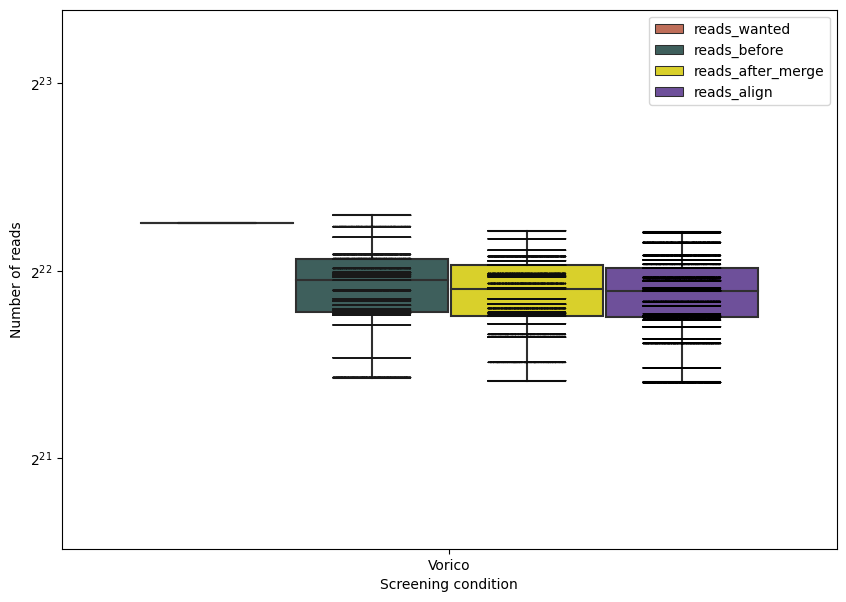

In [11]:
df_melt = pd.melt(df_sum, id_vars=['Antifungal'],value_vars=['reads_wanted', "reads_before",'reads_after_merge',"reads_align"], var_name='Reads control', value_name='Reads')

plt.figure(figsize=(10, 7))
custom_palette = sns.blend_palette(["#CF6448","#386461","#F6EA0E","#6C44A6"], n_colors=4)

ax = sns.boxplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",palette = custom_palette)
ax = sns.stripplot(data=df_melt, x="Antifungal", y="Reads", hue = "Reads control",color="black",dodge=True, jitter=0.2, size=1)

plt.ylim(1500000, 11000000)

plt.yscale('log', base=2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:4], labels[:4])

plt.xlabel('Screening condition')
plt.ylabel('Number of reads')

plt.show()

In [12]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [13]:
# remove wt, they have a count of 0 as they are not variants

ite = 0

for i in df_sum.iterrows() :
    
    first_row = df_sum.loc[ite]
    
    position = first_row['position']
    codon_wt = wt_dict[position]
    
    if first_row['codon'] == codon_wt :

        df_sum = df_sum.drop(ite)
        
    ite = ite+1   
    
df_sum = df_sum.reset_index()
df_sum

index              Condition  position codon  Timepoint Antifungal  \
0          0  CaERG11_0_Vorico_F1_A        55   AAA          0     Vorico   
1          1  CaERG11_0_Vorico_F1_A        55   AAC          0     Vorico   
2          2  CaERG11_0_Vorico_F1_A        55   AAG          0     Vorico   
3          3  CaERG11_0_Vorico_F1_A        55   AAT          0     Vorico   
4          4  CaERG11_0_Vorico_F1_A        55   ACC          0     Vorico   
...      ...                    ...       ...   ...        ...        ...   
47947  48853  CaERG11_2_Vorico_F4_C       511   TGT          2     Vorico   
47948  48854  CaERG11_2_Vorico_F4_C       511   TTA          2     Vorico   
47949  48855  CaERG11_2_Vorico_F4_C       511   TTC          2     Vorico   
47950  48856  CaERG11_2_Vorico_F4_C       511   TTG          2     Vorico   
47951  48857  CaERG11_2_Vorico_F4_C       511   TTT          2     Vorico   

      Fragment Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A   0.000000       34.0       5000000       5146785   
1           F1         A   0.000000       29.0       5000000       5146785   
2           F1         A   0.000000       49.0       5000000       5146785   
3           F1         A   0.000000       11.0       5000000       5146785   
4           F1         A   0.000000       93.0       5000000       5146785   
...        ...       ...        ...        ...           ...           ...   
47947       F4         C  10.128475     1398.0       5000000       4383226   
47948       F4         C  10.128475      694.0       5000000       4383226   
47949       F4         C  10.128475     2986.0       5000000       4383226   
47950       F4         C  10.128475      681.0       5000000       4383226   
47951       F4         C  10.128475     3675.0       5000000       4383226   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  
0                4857951           1568721      4828008    252934  
1                4857951           1568721      4828008    252934  
2                4857951           1568721      4828008    252934  
3                4857951           1568721      4828008    252934  
4                4857951           1568721      4828008    252934  
...                  ...               ...          ...       ...  
47947            4347950            987325      4291470    160649  
47948            4347950            987325      4291470    160649  
47949            4347950            987325      4291470    160649  
47950            4347950            987325      4291470    160649  
47951            4347950            987325      4291470    160649  

[47952 rows x 16 columns]

In [14]:
#Now we summed the lanes we can put more info in the df : reads in log and normalized. 
#You have to add +1 to the number of reads if you want to be able to get the log2

df_sum['nbr_reads_log'] = np.log2(df_sum['nbr_reads']+1)
df_sum['norm_reads'] = ((df_sum['nbr_reads']+1) / df_sum['reads_align'])
df_sum['norm_reads_log'] = np.log2(df_sum['norm_reads'])

df_sum=df_sum.reset_index()
df_sum = df_sum.drop("index",axis=1)

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date
df_sum.to_csv(f"c:{name}.csv")  

# 3- Selection coefficient

In [15]:
#open the variants counts with summed lanes

name = "Variant_count_Lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
df_v = pd.read_csv(name, header=0, index_col = 0)
df_v

level_0              Condition  position codon  Timepoint Antifungal  \
0            0  CaERG11_0_Vorico_F1_A        55   AAA          0     Vorico   
1            1  CaERG11_0_Vorico_F1_A        55   AAC          0     Vorico   
2            2  CaERG11_0_Vorico_F1_A        55   AAG          0     Vorico   
3            3  CaERG11_0_Vorico_F1_A        55   AAT          0     Vorico   
4            4  CaERG11_0_Vorico_F1_A        55   ACC          0     Vorico   
...        ...                    ...       ...   ...        ...        ...   
47947    47947  CaERG11_2_Vorico_F4_C       511   TGT          2     Vorico   
47948    47948  CaERG11_2_Vorico_F4_C       511   TTA          2     Vorico   
47949    47949  CaERG11_2_Vorico_F4_C       511   TTC          2     Vorico   
47950    47950  CaERG11_2_Vorico_F4_C       511   TTG          2     Vorico   
47951    47951  CaERG11_2_Vorico_F4_C       511   TTT          2     Vorico   

      Fragment Replicate         OD  nbr_reads  reads_wanted  reads_before  \
0           F1         A   0.000000       34.0       5000000       5146785   
1           F1         A   0.000000       29.0       5000000       5146785   
2           F1         A   0.000000       49.0       5000000       5146785   
3           F1         A   0.000000       11.0       5000000       5146785   
4           F1         A   0.000000       93.0       5000000       5146785   
...        ...       ...        ...        ...           ...           ...   
47947       F4         C  10.128475     1398.0       5000000       4383226   
47948       F4         C  10.128475      694.0       5000000       4383226   
47949       F4         C  10.128475     2986.0       5000000       4383226   
47950       F4         C  10.128475      681.0       5000000       4383226   
47951       F4         C  10.128475     3675.0       5000000       4383226   

       reads_after_merge  nbr_reads_single  reads_align  reads_wt  \
0                4857951           1568721      4828008    252934   
1                4857951           1568721      4828008    252934   
2                4857951           1568721      4828008    252934   
3                4857951           1568721      4828008    252934   
4                4857951           1568721      4828008    252934   
...                  ...               ...          ...       ...   
47947            4347950            987325      4291470    160649   
47948            4347950            987325      4291470    160649   
47949            4347950            987325      4291470    160649   
47950            4347950            987325      4291470    160649   
47951            4347950            987325      4291470    160649   

       nbr_reads_log  norm_reads  norm_reads_log  
0           5.129283    0.000007      -17.073714  
1           4.906891    0.000006      -17.296106  
2           5.643856    0.000010      -16.559140  
3           3.584963    0.000002      -18.618034  
4           6.554589    0.000019      -15.648408  
...              ...         ...             ...  
47947      10.450180    0.000326      -11.582860  
47948       9.440869    0.000162      -12.592171  
47949      11.544482    0.000696      -10.488559  
47950       9.413628    0.000159      -12.619413  
47951      11.843921    0.000857      -10.189119  

[47952 rows x 19 columns]

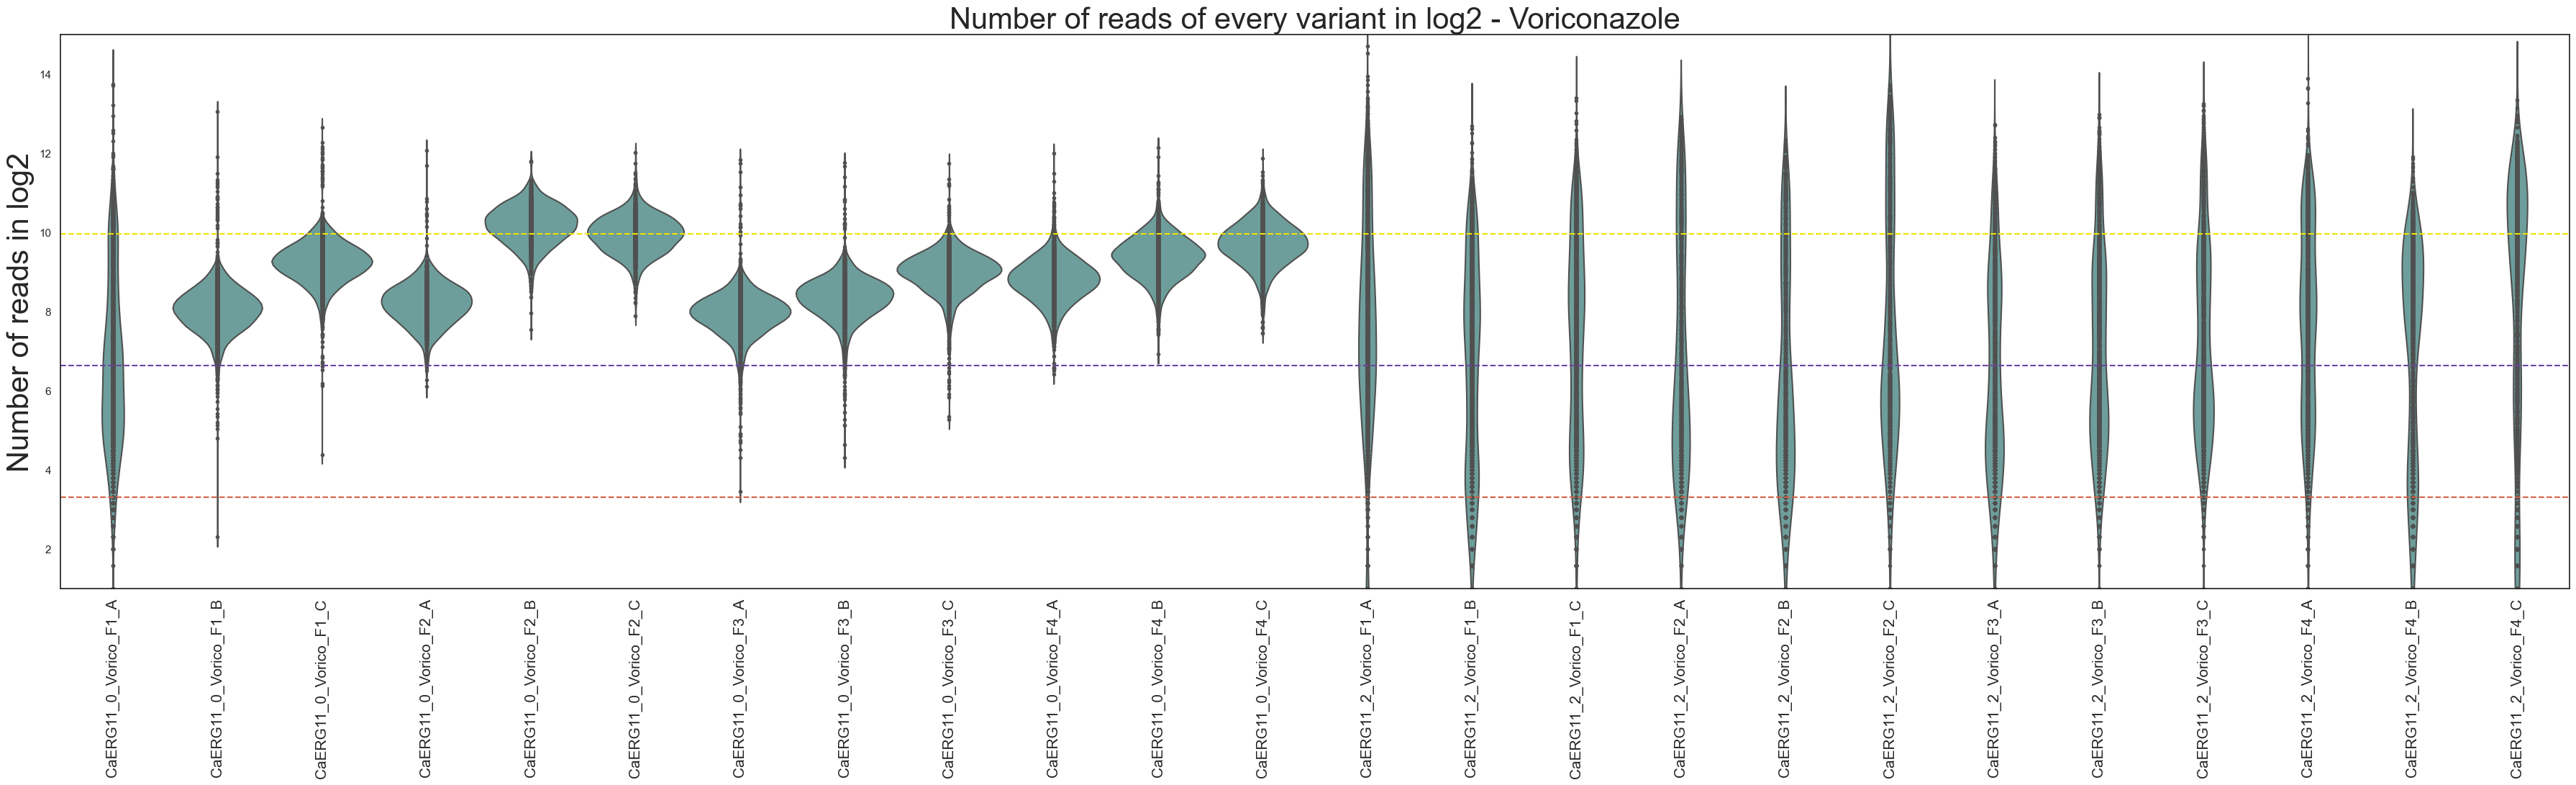

In [16]:

sns.set_style("white")

row = 0
sns.set_theme(style="white", palette=None)
plt.figure(figsize=(45,10))

sns.violinplot(data = df_v, x = 'Condition', y = 'nbr_reads_log',  inner = "point",width=1, color = "#65A6A2")
plt.ylabel("Number of reads in log2",fontsize = 30)
plt.xlabel("")
plt.tick_params(axis="x", labelsize=15, rotation = 90) 
title = condition
plt.title(title, fontsize = 40)
plt.axhline(9.97, color="#EEE304", linestyle="--")
plt.axhline(6.64, color = "#6C44A6", linestyle="--")
plt.axhline(3.32, color = "#D06448", linestyle="--")
plt.ylim(1, 15)


plt.title(f'Number of reads of every variant in log2 - {condition}',y=1, fontsize=30)

name = "./violin_plot_reads_all_log2_lanes_summed_" + condition + "_" + experiment + "_" + date + ".csv"
plt.savefig(f'{name}.png', transparent=True, dpi=400, bbox_inches='tight')

In [17]:
##remove F1 replicate A as it's ugly

df_v = df_v.drop(df_v[(df_v['Fragment'] == 'F1') & (df_v['Replicate'] == 'A')].index)

In [18]:
#Get a wide format with reads at every timepoint

#reads norm not in log
df_wide_tp = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"], 
                            columns= "Timepoint", values="norm_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tp=df_wide_tp[colus]

df_wide_tp = df_wide_tp.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tp = df_wide_tp.rename(columns={0: 'freq_tp0', 1 : "freq_tp1",
                                        2 : "freq_tp2", 3 : "freq_tp3"}) #remove 3 if no tp3

df_wide_tp

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2
0                55   AAA     Vorico       F1         B  0.000056  0.000004
1                55   AAA     Vorico       F1         C  0.000128  0.000009
2                55   AAC     Vorico       F1         B  0.000043  0.000004
3                55   AAC     Vorico       F1         C  0.000104  0.000009
4                55   AAG     Vorico       F1         B  0.000062  0.000002
...             ...   ...        ...      ...       ...       ...       ...
21134           511   TTG     Vorico       F4         B  0.000141  0.000052
21135           511   TTG     Vorico       F4         C  0.000165  0.000159
21136           511   TTT     Vorico       F4         A  0.000079  0.000612
21137           511   TTT     Vorico       F4         B  0.000114  0.000227
21138           511   TTT     Vorico       F4         C  0.000155  0.000857

[21139 rows x 7 columns]

In [19]:
#df wide with raw nbr reads
df_wide_tpnbr = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="nbr_reads")

colus = df_sum['Timepoint'].unique()
df_wide_tpnbr=df_wide_tpnbr[colus]

df_wide_tpnbr = df_wide_tpnbr.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpnbr = df_wide_tpnbr.rename(columns={0: 'nbr_tp0', 1 : "nbr_tp1",
                                              2 : "nbr_tp2", 3 : "nbr_tp3"}) #remove 3 if no tp3
df_wide_tpnbr

Timepoint  position codon Antifungal Fragment Replicate  nbr_tp0  nbr_tp2
0                55   AAA     Vorico       F1         B    218.0     14.0
1                55   AAA     Vorico       F1         C    498.0     24.0
2                55   AAC     Vorico       F1         B    167.0     13.0
3                55   AAC     Vorico       F1         C    406.0     23.0
4                55   AAG     Vorico       F1         B    241.0      8.0
...             ...   ...        ...      ...       ...      ...      ...
21134           511   TTG     Vorico       F4         B    576.0    185.0
21135           511   TTG     Vorico       F4         C    767.0    681.0
21136           511   TTT     Vorico       F4         A    345.0   2472.0
21137           511   TTT     Vorico       F4         B    467.0    805.0
21138           511   TTT     Vorico       F4         C    719.0   3675.0

[21139 rows x 7 columns]

In [20]:
#df wide with OD
df_wide_tpod = pd.pivot_table(df_v, index=["position","codon","Antifungal","Fragment", "Replicate"],
                               columns= "Timepoint", values="OD")

colus = df_sum['Timepoint'].unique()
df_wide_tpod=df_wide_tpod[colus]

df_wide_tpod = df_wide_tpod.reset_index(level=["position","codon","Replicate","Antifungal","Fragment"])
df_wide_tpod = df_wide_tpod.rename(columns={0: 'OD_tp0', 1 : "OD_tp1",
                                              2 : "OD_tp2", 3 : "OD_tp3"}) #remove 3 if no tp3
df_wide_tpod

Timepoint  position codon Antifungal Fragment Replicate  OD_tp0     OD_tp2
0                55   AAA     Vorico       F1         B     0.0   9.189427
1                55   AAA     Vorico       F1         C     0.0   8.881430
2                55   AAC     Vorico       F1         B     0.0   9.189427
3                55   AAC     Vorico       F1         C     0.0   8.881430
4                55   AAG     Vorico       F1         B     0.0   9.189427
...             ...   ...        ...      ...       ...     ...        ...
21134           511   TTG     Vorico       F4         B     0.0  10.106516
21135           511   TTG     Vorico       F4         C     0.0  10.128475
21136           511   TTT     Vorico       F4         A     0.0   7.925838
21137           511   TTT     Vorico       F4         B     0.0  10.106516
21138           511   TTT     Vorico       F4         C     0.0  10.128475

[21139 rows x 7 columns]

In [21]:
#merge wide with frequencies,raw nbrs of reads and od
merged_df = pd.merge(df_wide_tp, df_wide_tpnbr, on=['position', 'codon', "Antifungal", "Fragment", "Replicate"])

merged_df = pd.merge(merged_df, df_wide_tpod, on=['position', 'codon', "Antifungal", "Fragment", 
                                                    "Replicate"])
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Vorico       F1         B  0.000056  0.000004   
1                55   AAA     Vorico       F1         C  0.000128  0.000009   
2                55   AAC     Vorico       F1         B  0.000043  0.000004   
3                55   AAC     Vorico       F1         C  0.000104  0.000009   
4                55   AAG     Vorico       F1         B  0.000062  0.000002   
...             ...   ...        ...      ...       ...       ...       ...   
21134           511   TTG     Vorico       F4         B  0.000141  0.000052   
21135           511   TTG     Vorico       F4         C  0.000165  0.000159   
21136           511   TTT     Vorico       F4         A  0.000079  0.000612   
21137           511   TTT     Vorico       F4         B  0.000114  0.000227   
21138           511   TTT     Vorico       F4         C  0.000155  0.000857   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  
0            218.0     14.0     0.0   9.189427  
1            498.0     24.0     0.0   8.881430  
2            167.0     13.0     0.0   9.189427  
3            406.0     23.0     0.0   8.881430  
4            241.0      8.0     0.0   9.189427  
...            ...      ...     ...        ...  
21134        576.0    185.0     0.0  10.106516  
21135        767.0    681.0     0.0  10.128475  
21136        345.0   2472.0     0.0   7.925838  
21137        467.0    805.0     0.0  10.106516  
21138        719.0   3675.0     0.0  10.128475  

[21139 rows x 11 columns]

In [22]:
#log2foldchange calculation

merged_df['log2(tp2/tp0)'] = np.log2((df_wide_tp["freq_tp2"] / df_wide_tp["freq_tp0"]))

 


merged_df = merged_df.rename(columns={'log2(tp2/tp0)': 'l2fc_0_2'})

merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Vorico       F1         B  0.000056  0.000004   
1                55   AAA     Vorico       F1         C  0.000128  0.000009   
2                55   AAC     Vorico       F1         B  0.000043  0.000004   
3                55   AAC     Vorico       F1         C  0.000104  0.000009   
4                55   AAG     Vorico       F1         B  0.000062  0.000002   
...             ...   ...        ...      ...       ...       ...       ...   
21134           511   TTG     Vorico       F4         B  0.000141  0.000052   
21135           511   TTG     Vorico       F4         C  0.000165  0.000159   
21136           511   TTT     Vorico       F4         A  0.000079  0.000612   
21137           511   TTT     Vorico       F4         B  0.000114  0.000227   
21138           511   TTT     Vorico       F4         C  0.000155  0.000857   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  
0            218.0     14.0     0.0   9.189427 -3.789297  
1            498.0     24.0     0.0   8.881430 -3.827725  
2            167.0     13.0     0.0   9.189427 -3.506363  
3            406.0     23.0     0.0   8.881430 -3.592607  
4            241.0      8.0     0.0   9.189427 -4.670339  
...            ...      ...     ...        ...       ...  
21134        576.0    185.0     0.0  10.106516 -1.427374  
21135        767.0    681.0     0.0  10.128475 -0.055108  
21136        345.0   2472.0     0.0   7.925838  2.947852  
21137        467.0    805.0     0.0  10.106516  0.990166  
21138        719.0   3675.0     0.0  10.128475  2.468295  

[21139 rows x 12 columns]

In [23]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in merged_df.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
merged_df["aa"] = aa_list
merged_df

Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   AAA     Vorico       F1         B  0.000056  0.000004   
1                55   AAA     Vorico       F1         C  0.000128  0.000009   
2                55   AAC     Vorico       F1         B  0.000043  0.000004   
3                55   AAC     Vorico       F1         C  0.000104  0.000009   
4                55   AAG     Vorico       F1         B  0.000062  0.000002   
...             ...   ...        ...      ...       ...       ...       ...   
21134           511   TTG     Vorico       F4         B  0.000141  0.000052   
21135           511   TTG     Vorico       F4         C  0.000165  0.000159   
21136           511   TTT     Vorico       F4         A  0.000079  0.000612   
21137           511   TTT     Vorico       F4         B  0.000114  0.000227   
21138           511   TTT     Vorico       F4         C  0.000155  0.000857   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0            218.0     14.0     0.0   9.189427 -3.789297  K  
1            498.0     24.0     0.0   8.881430 -3.827725  K  
2            167.0     13.0     0.0   9.189427 -3.506363  N  
3            406.0     23.0     0.0   8.881430 -3.592607  N  
4            241.0      8.0     0.0   9.189427 -4.670339  K  
...            ...      ...     ...        ...       ... ..  
21134        576.0    185.0     0.0  10.106516 -1.427374  L  
21135        767.0    681.0     0.0  10.128475 -0.055108  L  
21136        345.0   2472.0     0.0   7.925838  2.947852  F  
21137        467.0    805.0     0.0  10.106516  0.990166  F  
21138        719.0   3675.0     0.0  10.128475  2.468295  F  

[21139 rows x 13 columns]

In [24]:
#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [25]:
#open df with wt positions

WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0)

aa_wt1 = pd.melt(WT_annot, id_vars=['aa'])

#keep only WT rows

aa_wt1 = aa_wt1[aa_wt1['value'] == 'o'].reset_index(drop=True)

#make a dictionnary of position + wt aa

aa_dict = dict(zip(aa_wt1['variable'], aa_wt1['aa']))

In [26]:
# get all the wts infos in our df

df_wt = merged_df  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.reset_index()
df_wt  # Outputting the filtered DataFrame

Timepoint  index  position codon Antifungal Fragment Replicate  freq_tp0  \
0             14        55   ATC     Vorico       F1         B  0.000060   
1             15        55   ATC     Vorico       F1         C  0.000090   
2             18        55   ATT     Vorico       F1         B  0.000059   
3             19        55   ATT     Vorico       F1         C  0.000124   
4            224        58   TTT     Vorico       F1         B  0.000122   
..           ...       ...   ...        ...      ...       ...       ...   
705        21128       511   TTA     Vorico       F4         B  0.000126   
706        21129       511   TTA     Vorico       F4         C  0.000153   
707        21133       511   TTG     Vorico       F4         A  0.000093   
708        21134       511   TTG     Vorico       F4         B  0.000141   
709        21135       511   TTG     Vorico       F4         C  0.000165   

Timepoint  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0          0.000042    232.0    152.0     0.0   9.189427 -0.528199  I  
1          0.000085    351.0    236.0     0.0   8.881430 -0.079373  I  
2          0.000054    228.0    199.0     0.0   9.189427 -0.116748  I  
3          0.000105    482.0    291.0     0.0   8.881430 -0.234740  I  
4          0.000117    473.0    431.0     0.0   9.189427 -0.055256  F  
..              ...      ...      ...     ...        ...       ... ..  
705        0.000049    516.0    172.0     0.0  10.106516 -1.373498  L  
706        0.000162    712.0    694.0     0.0  10.128475  0.079338  L  
707        0.000046    404.0    183.0     0.0   7.925838 -1.027782  L  
708        0.000052    576.0    185.0     0.0  10.106516 -1.427374  L  
709        0.000159    767.0    681.0     0.0  10.128475 -0.055108  L  

[710 rows x 14 columns]

In [27]:
# get all the synonymous wts infos, they are the most representative of wt behaviour as they are in frequencies similar
# to other variants in comparison with wt that is in higher frequency and correspond only to one measure

df_wt_syn = df_wt

ite = 0

for i in df_wt_syn.iterrows() :
    
    first_row = df_wt_syn.loc[ite]
    
    position = first_row['position']
    aa_wt = aa_dict[position]
    codon_wt = wt_dict[position]
    print(first_row['codon'])
    
    if first_row['codon'] == codon_wt :

        df_wt_syn = df_wt_syn.drop(ite)
        print("remove : " + str(position) + codon_wt)
        
    ite = ite+1   
    
df_wt_syn = df_wt_syn.reset_index().drop("index",axis=1).drop("level_0",axis=1)
df_wt_syn

ATC
ATC
ATT
ATT
TTT
TTT
GGA
GGA
GGT
GGT
TCC
TCC
TCT
TCT
GCC
GCC
GCT
GCT
GCC
GCC
GCT
GCT
TCC
TCC
TAC
TAC
GGA
GGA
CAG
CAG
CAG
CAG
CCA
CCA
CCT
CCT
TAC
TAC
TTC
TTC
TTC
TTC
TTC
TTC
TTA
TTA
TTG
TTG
TTA
TTA
TTG
TTG
GGA
GGA
GGT
GGT
AAG
AAG
GTC
GTC
GTT
GTT
GGA
GGA
CAT
CAT
GAG
GAG
TTC
TTC
GTT
GTT
TTT
TTT
AAC
AAC
GCC
GCC
GCT
GCT
TTG
TTG
GTT
GTT
TCC
TCC
GCC
GCC
GAG
GAG
GAC
GAC
GCC
GCC
GCT
GCT
TAT
TAT
AAG
AAG
CAT
CAT
TTG
TTG
ACC
ACC
ACT
ACT
ACC
ACC
CCA
CCA
CCT
CCT
GTC
GTC
GTT
GTT
TTT
TTT
GGT
GGT
AAA
AAA
GGT
GGT
GTC
GTC
ATT
ATT
TAT
TAT
GAC
GAC
TGC
TGC
CCA
CCA
CCT
CCT
AAT
AAT
TCC
TCC
TCT
TCT
AGA
AGA
TTA
TTA
TTG
TTG
GAA
GAA
CAA
CAA
AAG
AAG
AAA
AAA
TTC
TTC
GCC
GCC
AAG
AAG
TTT
TTT
GCC
GCC
GCT
GCT
TTA
TTA
TTG
TTG
ACC
ACC
TCC
TCC
TCC
TCC
TCC
TCT
TCT
TCT
TCT
TCT
TTT
TTT
TTT
TTT
TTT
TAC
TAC
TAC
TAC
TAC
ATC
ATC
ATC
ATC
ATC
CAG
CAG
CAG
ATT
ATT
ATT
ACT
ACT
ACT
ATC
ATC
ATC
ACT
ACT
ACT
GCT
GCT
GCT
TCC
TCC
TCC
TCT
TCT
TCT
AGA
AGA
AGA
CGT
CGT
CGT
TCT
TCT
TCT
TTG
TTG
TTG
TTC
TTC
TTC
TTA
TTA
TTA
GAC
GAC
GAC
AAG
AAG


Timepoint  position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0                55   ATC     Vorico       F1         B  0.000060  0.000042   
1                55   ATC     Vorico       F1         C  0.000090  0.000085   
2                55   ATT     Vorico       F1         B  0.000059  0.000054   
3                55   ATT     Vorico       F1         C  0.000124  0.000105   
4                58   TTT     Vorico       F1         B  0.000122  0.000117   
..              ...   ...        ...      ...       ...       ...       ...   
705             511   TTA     Vorico       F4         B  0.000126  0.000049   
706             511   TTA     Vorico       F4         C  0.000153  0.000162   
707             511   TTG     Vorico       F4         A  0.000093  0.000046   
708             511   TTG     Vorico       F4         B  0.000141  0.000052   
709             511   TTG     Vorico       F4         C  0.000165  0.000159   

Timepoint  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  
0            232.0    152.0     0.0   9.189427 -0.528199  I  
1            351.0    236.0     0.0   8.881430 -0.079373  I  
2            228.0    199.0     0.0   9.189427 -0.116748  I  
3            482.0    291.0     0.0   8.881430 -0.234740  I  
4            473.0    431.0     0.0   9.189427 -0.055256  F  
..             ...      ...     ...        ...       ... ..  
705          516.0    172.0     0.0  10.106516 -1.373498  L  
706          712.0    694.0     0.0  10.128475  0.079338  L  
707          404.0    183.0     0.0   7.925838 -1.027782  L  
708          576.0    185.0     0.0  10.106516 -1.427374  L  
709          767.0    681.0     0.0  10.128475 -0.055108  L  

[710 rows x 13 columns]

In [28]:
#wt for every fragment and replicate

wt_frag = df_wt_syn.groupby("Fragment")
f1_wt = wt_frag.get_group("F1").reset_index()
f2_wt = wt_frag.get_group("F2").reset_index()
f3_wt = wt_frag.get_group("F3").reset_index()
f4_wt = wt_frag.get_group("F4").reset_index()

wt_frag1_r = f1_wt.groupby("Replicate")

f1_wtB = wt_frag1_r.get_group("B").reset_index()
f1_wtC = wt_frag1_r.get_group("C").reset_index()

wt_frag2_r = f2_wt.groupby("Replicate")
f2_wtA = wt_frag2_r.get_group("A").reset_index()
f2_wtB = wt_frag2_r.get_group("B").reset_index()
f2_wtC = wt_frag2_r.get_group("C").reset_index()

wt_frag3_r = f3_wt.groupby("Replicate")
f3_wtA = wt_frag3_r.get_group("A").reset_index()
f3_wtB = wt_frag3_r.get_group("B").reset_index()
f3_wtC = wt_frag3_r.get_group("C").reset_index()

wt_frag4_r = f4_wt.groupby("Replicate")
f4_wtA = wt_frag4_r.get_group("A").reset_index()
f4_wtB = wt_frag4_r.get_group("B").reset_index()
f4_wtC = wt_frag4_r.get_group("C").reset_index()

merged_df["select_coef"] = np.nan #add an empty column to add our selection coefficient
merged_df_frag = merged_df.groupby("Fragment")

m1 = merged_df_frag.get_group("F1")
m1r = m1.groupby("Replicate")

m1_B = m1r.get_group("B").reset_index()
m1_C = m1r.get_group("C").reset_index()

m2 = merged_df_frag.get_group("F2")
m2r = m2.groupby("Replicate")
m2_A = m2r.get_group("A").reset_index()
m2_B = m2r.get_group("B").reset_index()
m2_C = m2r.get_group("C").reset_index()

m3 = merged_df_frag.get_group("F3")
m3r = m3.groupby("Replicate")
m3_A = m3r.get_group("A").reset_index()
m3_B = m3r.get_group("B").reset_index()
m3_C = m3r.get_group("C").reset_index()

m4 = merged_df_frag.get_group("F4")
m4r = m4.groupby("Replicate")
m4_A = m4r.get_group("A").reset_index()
m4_B = m4r.get_group("B").reset_index()
m4_C = m4r.get_group("C").reset_index()

In [29]:
rep_list = ["B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m1_" + str(r)
    df = globals()[name]
    wt_name = "f1_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df1 = pd.concat(df_list, axis=0)

concatenated_df1 

7.836690433886447e-05
0.0001476537122018


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA     Vorico       F1         B   
1                1      2        55   AAC     Vorico       F1         B   
2                2      4        55   AAG     Vorico       F1         B   
3                3      6        55   AAT     Vorico       F1         B   
4                4      8        55   ACC     Vorico       F1         B   
...            ...    ...       ...   ...        ...      ...       ...   
2832          2832   6097       162   TGT     Vorico       F1         C   
2833          2833   6102       162   TTA     Vorico       F1         C   
2834          2834   6107       162   TTC     Vorico       F1         C   
2835          2835   6112       162   TTG     Vorico       F1         C   
2836          2836   6117       162   TTT     Vorico       F1         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000056  0.000004    218.0     14.0     0.0  9.189427 -3.789297   
1          0.000043  0.000004    167.0     13.0     0.0  9.189427 -3.506363   
2          0.000062  0.000002    241.0      8.0     0.0  9.189427 -4.670339   
3          0.000037  0.000005    141.0     18.0     0.0  9.189427 -2.823220   
4          0.000032  0.000011    123.0     40.0     0.0  9.189427 -1.518045   
...             ...       ...      ...      ...     ...       ...       ...   
2832       0.000102  0.000056    398.0    155.0     0.0  8.881430 -0.863528   
2833       0.000159  0.000039    618.0    108.0     0.0  8.881430 -2.014296   
2834       0.000146  0.000012    567.0     32.0     0.0  8.881430 -3.614038   
2835       0.000161  0.000034    628.0     94.0     0.0  8.881430 -2.235745   
2836       0.000145  0.000024    563.0     66.0     0.0  8.881430 -2.582147   

Timepoint aa  select_coef   nbr_gen  
0          K    -0.418210  9.189427  
1          N    -0.387421  9.189427  
2          K    -0.514085  9.189427  
3          N    -0.313080  9.189427  
4          T    -0.171050  9.189427  
...       ..          ...       ...  
2832       C    -0.076996  8.881430  
2833       L    -0.206566  8.881430  
2834       F    -0.386688  8.881430  
2835       L    -0.231500  8.881430  
2836       F    -0.270503  8.881430  

[5674 rows x 17 columns]

In [30]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m2_" + str(r)
    df = globals()[name]
    wt_name = "f2_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df2 = pd.concat(df_list, axis=0)

concatenated_df2 

0.00018969325671635
0.00012139949567665
0.00029101491451435


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0   5378       154   AAA     Vorico       F2         A   
1                1   5383       154   AAC     Vorico       F2         A   
2                2   5388       154   AAG     Vorico       F2         A   
3                3   5393       154   AAT     Vorico       F2         A   
4                4   5398       154   ACC     Vorico       F2         A   
...            ...    ...       ...   ...        ...      ...       ...   
1151          1151   9450       280   TGT     Vorico       F2         C   
1152          1152   9456       280   TTA     Vorico       F2         C   
1153          1153   9462       280   TTC     Vorico       F2         C   
1154          1154   9468       280   TTG     Vorico       F2         C   
1155          1155   9474       280   TTT     Vorico       F2         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000087  0.000785    254.0   3085.0     0.0  8.897665  3.171726   
1          0.000066  0.000034    193.0    132.0     0.0  8.897665 -0.970073   
2          0.000086  0.000838    250.0   3291.0     0.0  8.897665  3.287762   
3          0.000053  0.000025    155.0     97.0     0.0  8.897665 -1.096135   
4          0.000093  0.000028    270.0    110.0     0.0  8.897665 -1.713176   
...             ...       ...      ...      ...     ...       ...       ...   
1151       0.000277  0.000016   1116.0     57.0     0.0  8.524528 -4.093380   
1152       0.000126  0.000165    508.0    589.0     0.0  8.524528  0.387101   
1153       0.000159  0.000017    640.0     59.0     0.0  8.524528 -3.243238   
1154       0.000157  0.000213    632.0    759.0     0.0  8.524528  0.437846   
1155       0.000139  0.000018    558.0     63.0     0.0  8.524528 -2.952652   

Timepoint aa  select_coef   nbr_gen  
0          K     0.251470  8.897665  
1          N    -0.214023  8.897665  
2          K     0.264512  8.897665  
3          N    -0.228190  8.897665  
4          T    -0.297539  8.897665  
...       ..          ...       ...  
1151       C    -0.513801  8.524528  
1152       L     0.011798  8.524528  
1153       F    -0.414072  8.524528  
1154       L     0.017751  8.524528  
1155       F    -0.379983  8.524528  

[3468 rows x 17 columns]

In [31]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m3_" + str(r)
    df = globals()[name]
    wt_name = "f3_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"]  
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df3 = pd.concat(df_list, axis=0)

concatenated_df3 

0.0001207444920855
0.0001289143403792
0.0001466914813178


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0   8809       276   AAA     Vorico       F3         A   
1                1   8815       276   AAC     Vorico       F3         A   
2                2   8821       276   AAG     Vorico       F3         A   
3                3   8827       276   AAT     Vorico       F3         A   
4                4   8833       276   ACC     Vorico       F3         A   
...            ...    ...       ...   ...        ...      ...       ...   
2014          2014  15843       406   TGT     Vorico       F3         C   
2015          2015  15849       406   TTA     Vorico       F3         C   
2016          2016  15855       406   TTC     Vorico       F3         C   
2017          2017  15861       406   TTG     Vorico       F3         C   
2018          2018  15867       406   TTT     Vorico       F3         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0    OD_tp2  l2fc_0_2  \
0          0.000080  0.000424    271.0   1583.0     0.0  8.621501  2.407820   
1          0.000059  0.000328    199.0   1227.0     0.0  8.621501  2.484165   
2          0.000083  0.000481    281.0   1797.0     0.0  8.621501  2.538552   
3          0.000099  0.000666    338.0   2490.0     0.0  8.621501  2.743294   
4          0.000066  0.000382    223.0   1427.0     0.0  8.621501  2.538352   
...             ...       ...      ...      ...     ...       ...       ...   
2014       0.000131  0.000124    418.0    550.0     0.0  8.155960 -0.073706   
2015       0.000220  0.000152    705.0    674.0     0.0  8.155960 -0.533589   
2016       0.000106  0.000134    339.0    594.0     0.0  8.155960  0.338547   
2017       0.000194  0.000154    620.0    682.0     0.0  8.155960 -0.331516   
2018       0.000188  0.000247    600.0   1093.0     0.0  8.155960  0.395368   

Timepoint aa  select_coef   nbr_gen  
0          K     0.209105  8.621501  
1          N     0.217960  8.621501  
2          K     0.224268  8.621501  
3          N     0.248016  8.621501  
4          T     0.224245  8.621501  
...       ..          ...       ...  
2014       C     0.018757  8.155960  
2015       L    -0.037629  8.155960  
2016       F     0.069304  8.155960  
2017       L    -0.012853  8.155960  
2018       F     0.076270  8.155960  

[6057 rows x 17 columns]

In [32]:
rep_list = ["A","B","C"]

ite=0
nbr_gen_list = []
select_coef_list = []
df_list = []

for r in rep_list :
        
    name = "m4_" + str(r)
    df = globals()[name]
    wt_name = "f4_wt" + str(r)
    df_wt = globals()[wt_name]
    df = df.reset_index()
    
    for i in range(len(df)) :
        
        first_row = df.loc[i]
            
        nbr_gen = first_row["OD_tp2"] 
        
        freq_mut_2 = first_row["freq_tp2"]
        freq_mut_0 = first_row["freq_tp0"]
        
        med_freq_wt_2 = df_wt["freq_tp2"].median()
        med_freq_wt_0 = df_wt["freq_tp0"].median()
            
        select_coef = np.log2((freq_mut_2 * med_freq_wt_0)/(freq_mut_0 * med_freq_wt_2))/nbr_gen
        
        nbr_gen_list.append(float(nbr_gen)) 
        select_coef_list.append(float(select_coef))

    print(med_freq_wt_2)   
    df['nbr_gen'] = nbr_gen_list
    df['select_coef'] = select_coef_list
    df_list.append(df)
    
    nbr_gen_list = []
    select_coef_list = []

concatenated_df4 = pd.concat(df_list, axis=0)

concatenated_df4 

6.395874178680684e-05
7.139329805996473e-05
0.0001666095766718


Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0  14530       401   AAA     Vorico       F4         A   
1                1  14536       401   AAC     Vorico       F4         A   
2                2  14542       401   AAG     Vorico       F4         A   
3                3  14548       401   AAT     Vorico       F4         A   
4                4  14554       401   ACC     Vorico       F4         A   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  21126       511   TGT     Vorico       F4         C   
1976          1976  21129       511   TTA     Vorico       F4         C   
1977          1977  21132       511   TTC     Vorico       F4         C   
1978          1978  21135       511   TTG     Vorico       F4         C   
1979          1979  21138       511   TTT     Vorico       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000099  0.000004    429.0     15.0     0.0   7.925838 -4.637759   
1          0.000188  0.000030    820.0    121.0     0.0   7.925838 -2.640067   
2          0.000118  0.000009    516.0     37.0     0.0   7.925838 -3.655659   
3          0.000105  0.000010    457.0     40.0     0.0   7.925838 -3.371218   
4          0.000106  0.000016    461.0     65.0     0.0   7.925838 -2.696921   
...             ...       ...      ...      ...     ...        ...       ...   
1975       0.000223  0.000326   1034.0   1398.0     0.0  10.128475  0.550992   
1976       0.000153  0.000162    712.0    694.0     0.0  10.128475  0.079338   
1977       0.000118  0.000696    546.0   2986.0     0.0  10.128475  2.565311   
1978       0.000165  0.000159    767.0    681.0     0.0  10.128475 -0.055108   
1979       0.000155  0.000857    719.0   3675.0     0.0  10.128475  2.468295   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.481930   7.925838  
1          N    -0.229882   7.925838  
2          K    -0.358019   7.925838  
3          N    -0.322131   7.925838  
4          T    -0.237055   7.925838  
...       ..          ...        ...  
1975       C     0.076491  10.128475  
1976       L     0.029924  10.128475  
1977       F     0.275368  10.128475  
1978       L     0.016650  10.128475  
1979       F     0.265790  10.128475  

[5940 rows x 17 columns]

In [33]:
###### save the df
F1_2_long = pd.concat([concatenated_df1 ,concatenated_df2 ],axis=0)
F3_4_long = pd.concat([concatenated_df3 , concatenated_df4 ],axis=0)
All_concat = pd.concat([F1_2_long, F3_4_long],axis=0)
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date
All_concat.to_csv(f"c:{name}.csv")  

All_concat

Timepoint  level_0  index  position codon Antifungal Fragment Replicate  \
0                0      0        55   AAA     Vorico       F1         B   
1                1      2        55   AAC     Vorico       F1         B   
2                2      4        55   AAG     Vorico       F1         B   
3                3      6        55   AAT     Vorico       F1         B   
4                4      8        55   ACC     Vorico       F1         B   
...            ...    ...       ...   ...        ...      ...       ...   
1975          1975  21126       511   TGT     Vorico       F4         C   
1976          1976  21129       511   TTA     Vorico       F4         C   
1977          1977  21132       511   TTC     Vorico       F4         C   
1978          1978  21135       511   TTG     Vorico       F4         C   
1979          1979  21138       511   TTT     Vorico       F4         C   

Timepoint  freq_tp0  freq_tp2  nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2  \
0          0.000056  0.000004    218.0     14.0     0.0   9.189427 -3.789297   
1          0.000043  0.000004    167.0     13.0     0.0   9.189427 -3.506363   
2          0.000062  0.000002    241.0      8.0     0.0   9.189427 -4.670339   
3          0.000037  0.000005    141.0     18.0     0.0   9.189427 -2.823220   
4          0.000032  0.000011    123.0     40.0     0.0   9.189427 -1.518045   
...             ...       ...      ...      ...     ...        ...       ...   
1975       0.000223  0.000326   1034.0   1398.0     0.0  10.128475  0.550992   
1976       0.000153  0.000162    712.0    694.0     0.0  10.128475  0.079338   
1977       0.000118  0.000696    546.0   2986.0     0.0  10.128475  2.565311   
1978       0.000165  0.000159    767.0    681.0     0.0  10.128475 -0.055108   
1979       0.000155  0.000857    719.0   3675.0     0.0  10.128475  2.468295   

Timepoint aa  select_coef    nbr_gen  
0          K    -0.418210   9.189427  
1          N    -0.387421   9.189427  
2          K    -0.514085   9.189427  
3          N    -0.313080   9.189427  
4          T    -0.171050   9.189427  
...       ..          ...        ...  
1975       C     0.076491  10.128475  
1976       L     0.029924  10.128475  
1977       F     0.275368  10.128475  
1978       L     0.016650  10.128475  
1979       F     0.265790  10.128475  

[21139 rows x 17 columns]

# 4- Control between replicates

In [34]:
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"
df_r = pd.read_csv(name, header=0, index_col = 0)
df_r = df_r.drop("level_0",axis=1).drop("index",axis=1)

<Axes:xlabel='Replicate', ylabel='Replicate'>

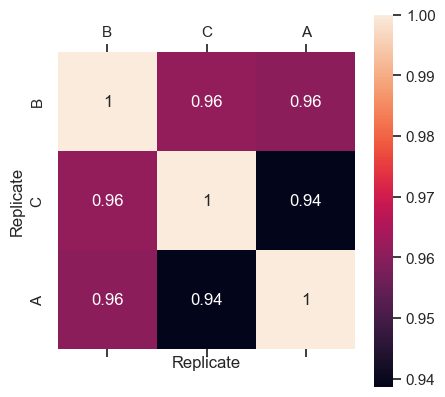

In [35]:
#Correlation condition 1

df_corr = pd.pivot_table(df_r, index=["position","codon","Fragment"], columns= "Replicate", values="select_coef")

colus2 = df_r['Replicate'].unique()
df_corr=df_corr[colus2]

plt.matshow(df_corr.corr())
corr_mat = df_corr.corr()
sns.heatmap(corr_mat, annot=True)

In [36]:
df_r

position codon Antifungal Fragment Replicate  freq_tp0  freq_tp2  \
0           55   AAA     Vorico       F1         B  0.000056  0.000004   
1           55   AAC     Vorico       F1         B  0.000043  0.000004   
2           55   AAG     Vorico       F1         B  0.000062  0.000002   
3           55   AAT     Vorico       F1         B  0.000037  0.000005   
4           55   ACC     Vorico       F1         B  0.000032  0.000011   
...        ...   ...        ...      ...       ...       ...       ...   
1975       511   TGT     Vorico       F4         C  0.000223  0.000326   
1976       511   TTA     Vorico       F4         C  0.000153  0.000162   
1977       511   TTC     Vorico       F4         C  0.000118  0.000696   
1978       511   TTG     Vorico       F4         C  0.000165  0.000159   
1979       511   TTT     Vorico       F4         C  0.000155  0.000857   

      nbr_tp0  nbr_tp2  OD_tp0     OD_tp2  l2fc_0_2 aa  select_coef    nbr_gen  
0       218.0     14.0     0.0   9.189427 -3.789297  K    -0.418210   9.189427  
1       167.0     13.0     0.0   9.189427 -3.506363  N    -0.387421   9.189427  
2       241.0      8.0     0.0   9.189427 -4.670339  K    -0.514085   9.189427  
3       141.0     18.0     0.0   9.189427 -2.823220  N    -0.313080   9.189427  
4       123.0     40.0     0.0   9.189427 -1.518045  T    -0.171050   9.189427  
...       ...      ...     ...        ...       ... ..          ...        ...  
1975   1034.0   1398.0     0.0  10.128475  0.550992  C     0.076491  10.128475  
1976    712.0    694.0     0.0  10.128475  0.079338  L     0.029924  10.128475  
1977    546.0   2986.0     0.0  10.128475  2.565311  F     0.275368  10.128475  
1978    767.0    681.0     0.0  10.128475 -0.055108  L     0.016650  10.128475  
1979    719.0   3675.0     0.0  10.128475  2.468295  F     0.265790  10.128475  

[21139 rows x 15 columns]

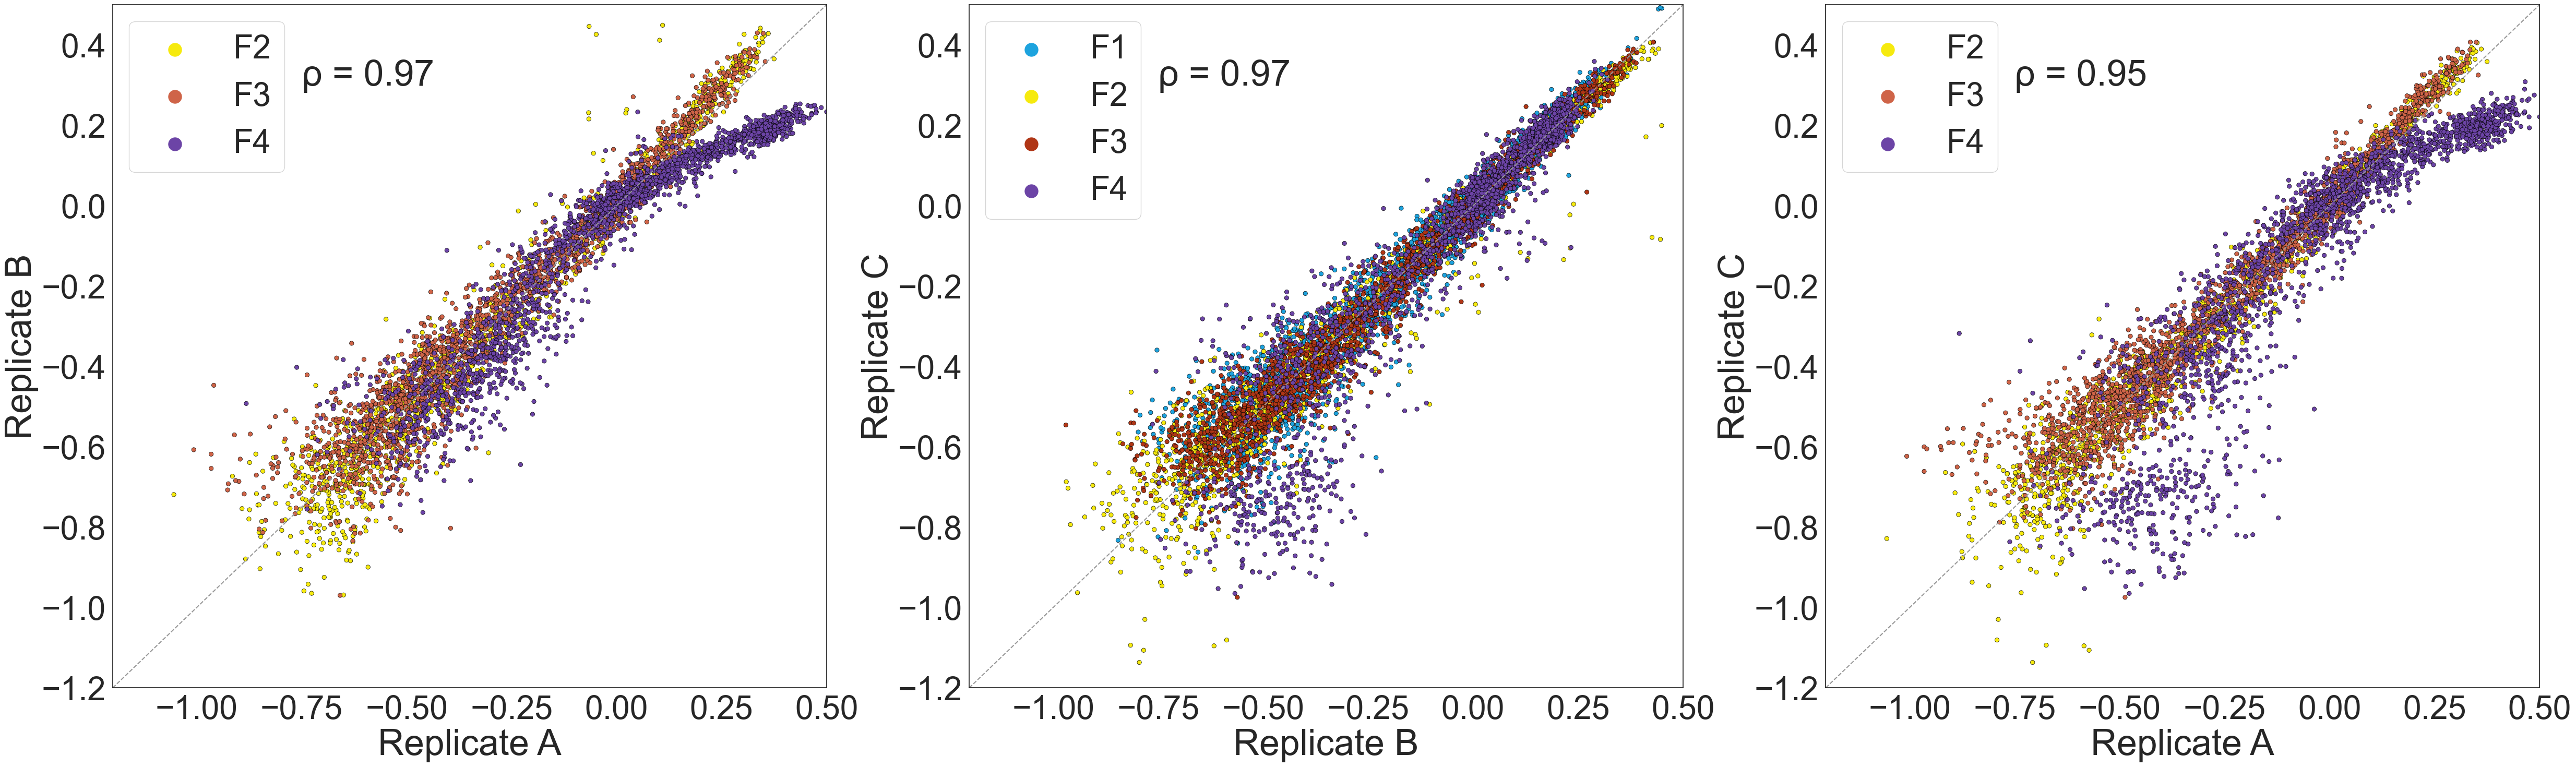

In [37]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")


r_list = ["A","B","A"]


r2_list = ["B","C","C"]

F_list = ["F1","F2","F3","F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(3) :    
    
    sns.set_theme(style="white")
    
    colors = ["#1DA3DE","#F6EA0E","#B03616","#6C44A6"]
    custom_palette = sns.set_palette(sns.color_palette(colors))
    
    rep1 = df_r_g.get_group(r_list[i]).reset_index()
    rep2 = df_r_g.get_group(r2_list[i]).reset_index()
    
    if r_list[i] == "A" :
        rep2 = rep2[rep2['Fragment'] != 'F1'].reset_index()
        colors = ["#F6EA0E","#CF6448","#6C44A6"]
        custom_palette = sns.set_palette(sns.color_palette(colors))
    
    sns.scatterplot(x=rep1["select_coef"],  y=rep2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = rep2["Fragment"],ax = axes[row])
    
    axes[row].set_ylabel("Replicate " + str(r2_list[i]), fontsize=50)
    axes[row].set_xlabel("Replicate " + str(r_list[i]), fontsize=50)
    
    #title = "Replicate " + str(r_list[i]) + " - Replicate " + str(r2_list[i])
    #axes[row].set_title(title, fontsize=45)
    
    axes[row].set_ylim(-1.2, 0.5)
    axes[row].set_xlim(-1.2, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-1.2, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
    
    result = sp.stats.spearmanr(rep1["select_coef"],rep2["select_coef"])
    coeff = result[0]
    p_value = "{:.1e}".format(result[1])
    R2 = coeff**2     
    
    text = "ρ = " + str(round(coeff,2))
    #+ "\np-value = "  + str(p_value)
    axes[row].text(-0.75,0.30, text , fontsize = 50)

        
    row +=1
    
fig.subplots_adjust(hspace=0.31)
#fig.suptitle('Correlation between the Selection coefficient of replicates - ' + condition, y=0.95, fontsize=50)

plt.rcParams['svg.fonttype'] = 'none'
name = "Regression_replicate_select_coeff_" + condition + "_" + experiment + "_" + date
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [38]:
#Get the median of the replicates

df_group = df_r.groupby(["position","codon","Antifungal","Fragment","aa"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","nbr_gen","select_coef"]
df_med = df_group[cols].median()

#reset index so the index becomes columns again
df_med = df_med.reset_index(level=["position","codon","Antifungal","Fragment","aa"])

name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_med.to_csv(name)  
df_med

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA     Vorico       F1  K  0.000092  0.000007 -3.808511   
1           55   AAC     Vorico       F1  N  0.000074  0.000006 -3.549485   
2           55   AAG     Vorico       F1  K  0.000109  0.000005 -4.589512   
3           55   AAT     Vorico       F1  N  0.000056  0.000008 -2.829400   
4           55   ACC     Vorico       F1  T  0.000051  0.000035 -0.876582   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT     Vorico       F4  C  0.000156  0.000147  0.495832   
7988       511   TTA     Vorico       F4  L  0.000126  0.000049 -0.742725   
7989       511   TTC     Vorico       F4  F  0.000100  0.000549  2.565311   
7990       511   TTG     Vorico       F4  L  0.000141  0.000052 -1.027782   
7991       511   TTT     Vorico       F4  F  0.000114  0.000612  2.468295   

      nbr_tp0  nbr_tp2    nbr_gen  select_coef  
0       358.0     19.0   9.035429    -0.414479  
1       286.5     18.0   9.035429    -0.385848  
2       424.0     13.0   9.035429    -0.500753  
3       215.5     23.0   9.035429    -0.306059  
4       197.5    102.0   9.035429    -0.088646  
...       ...      ...        ...          ...  
7987    635.0    545.0  10.106516     0.124462  
7988    516.0    172.0  10.106516     0.009505  
7989    407.0   2219.0  10.106516     0.275368  
7990    576.0    185.0  10.106516    -0.008399  
7991    467.0   2472.0  10.106516     0.265790  

[7992 rows x 12 columns]

# 5- Control between codons

In [39]:
name = "Select_coeff_median_replicates_" + condition + "_" + experiment + "_" + date + ".csv"
df_c = pd.read_csv(name, header=0, index_col = 0)
df_c

position codon Antifungal Fragment aa  freq_tp0  freq_tp2  l2fc_0_2  \
0           55   AAA     Vorico       F1  K  0.000092  0.000007 -3.808511   
1           55   AAC     Vorico       F1  N  0.000074  0.000006 -3.549485   
2           55   AAG     Vorico       F1  K  0.000109  0.000005 -4.589512   
3           55   AAT     Vorico       F1  N  0.000056  0.000008 -2.829400   
4           55   ACC     Vorico       F1  T  0.000051  0.000035 -0.876582   
...        ...   ...        ...      ... ..       ...       ...       ...   
7987       511   TGT     Vorico       F4  C  0.000156  0.000147  0.495832   
7988       511   TTA     Vorico       F4  L  0.000126  0.000049 -0.742725   
7989       511   TTC     Vorico       F4  F  0.000100  0.000549  2.565311   
7990       511   TTG     Vorico       F4  L  0.000141  0.000052 -1.027782   
7991       511   TTT     Vorico       F4  F  0.000114  0.000612  2.468295   

      nbr_tp0  nbr_tp2    nbr_gen  select_coef  
0       358.0     19.0   9.035429    -0.414479  
1       286.5     18.0   9.035429    -0.385848  
2       424.0     13.0   9.035429    -0.500753  
3       215.5     23.0   9.035429    -0.306059  
4       197.5    102.0   9.035429    -0.088646  
...       ...      ...        ...          ...  
7987    635.0    545.0  10.106516     0.124462  
7988    516.0    172.0  10.106516     0.009505  
7989    407.0   2219.0  10.106516     0.275368  
7990    576.0    185.0  10.106516    -0.008399  
7991    467.0   2472.0  10.106516     0.265790  

[7992 rows x 12 columns]

In [40]:
#add the corresponding aa to a list using the dictionary we define at the beginning and add to the df

aa_list = []

for _, row in df_c.iterrows():
    codon = row['codon']
    aa = DNA_Codons.get(codon)
    aa_list.append(aa)
    
df_c["aa"] = aa_list

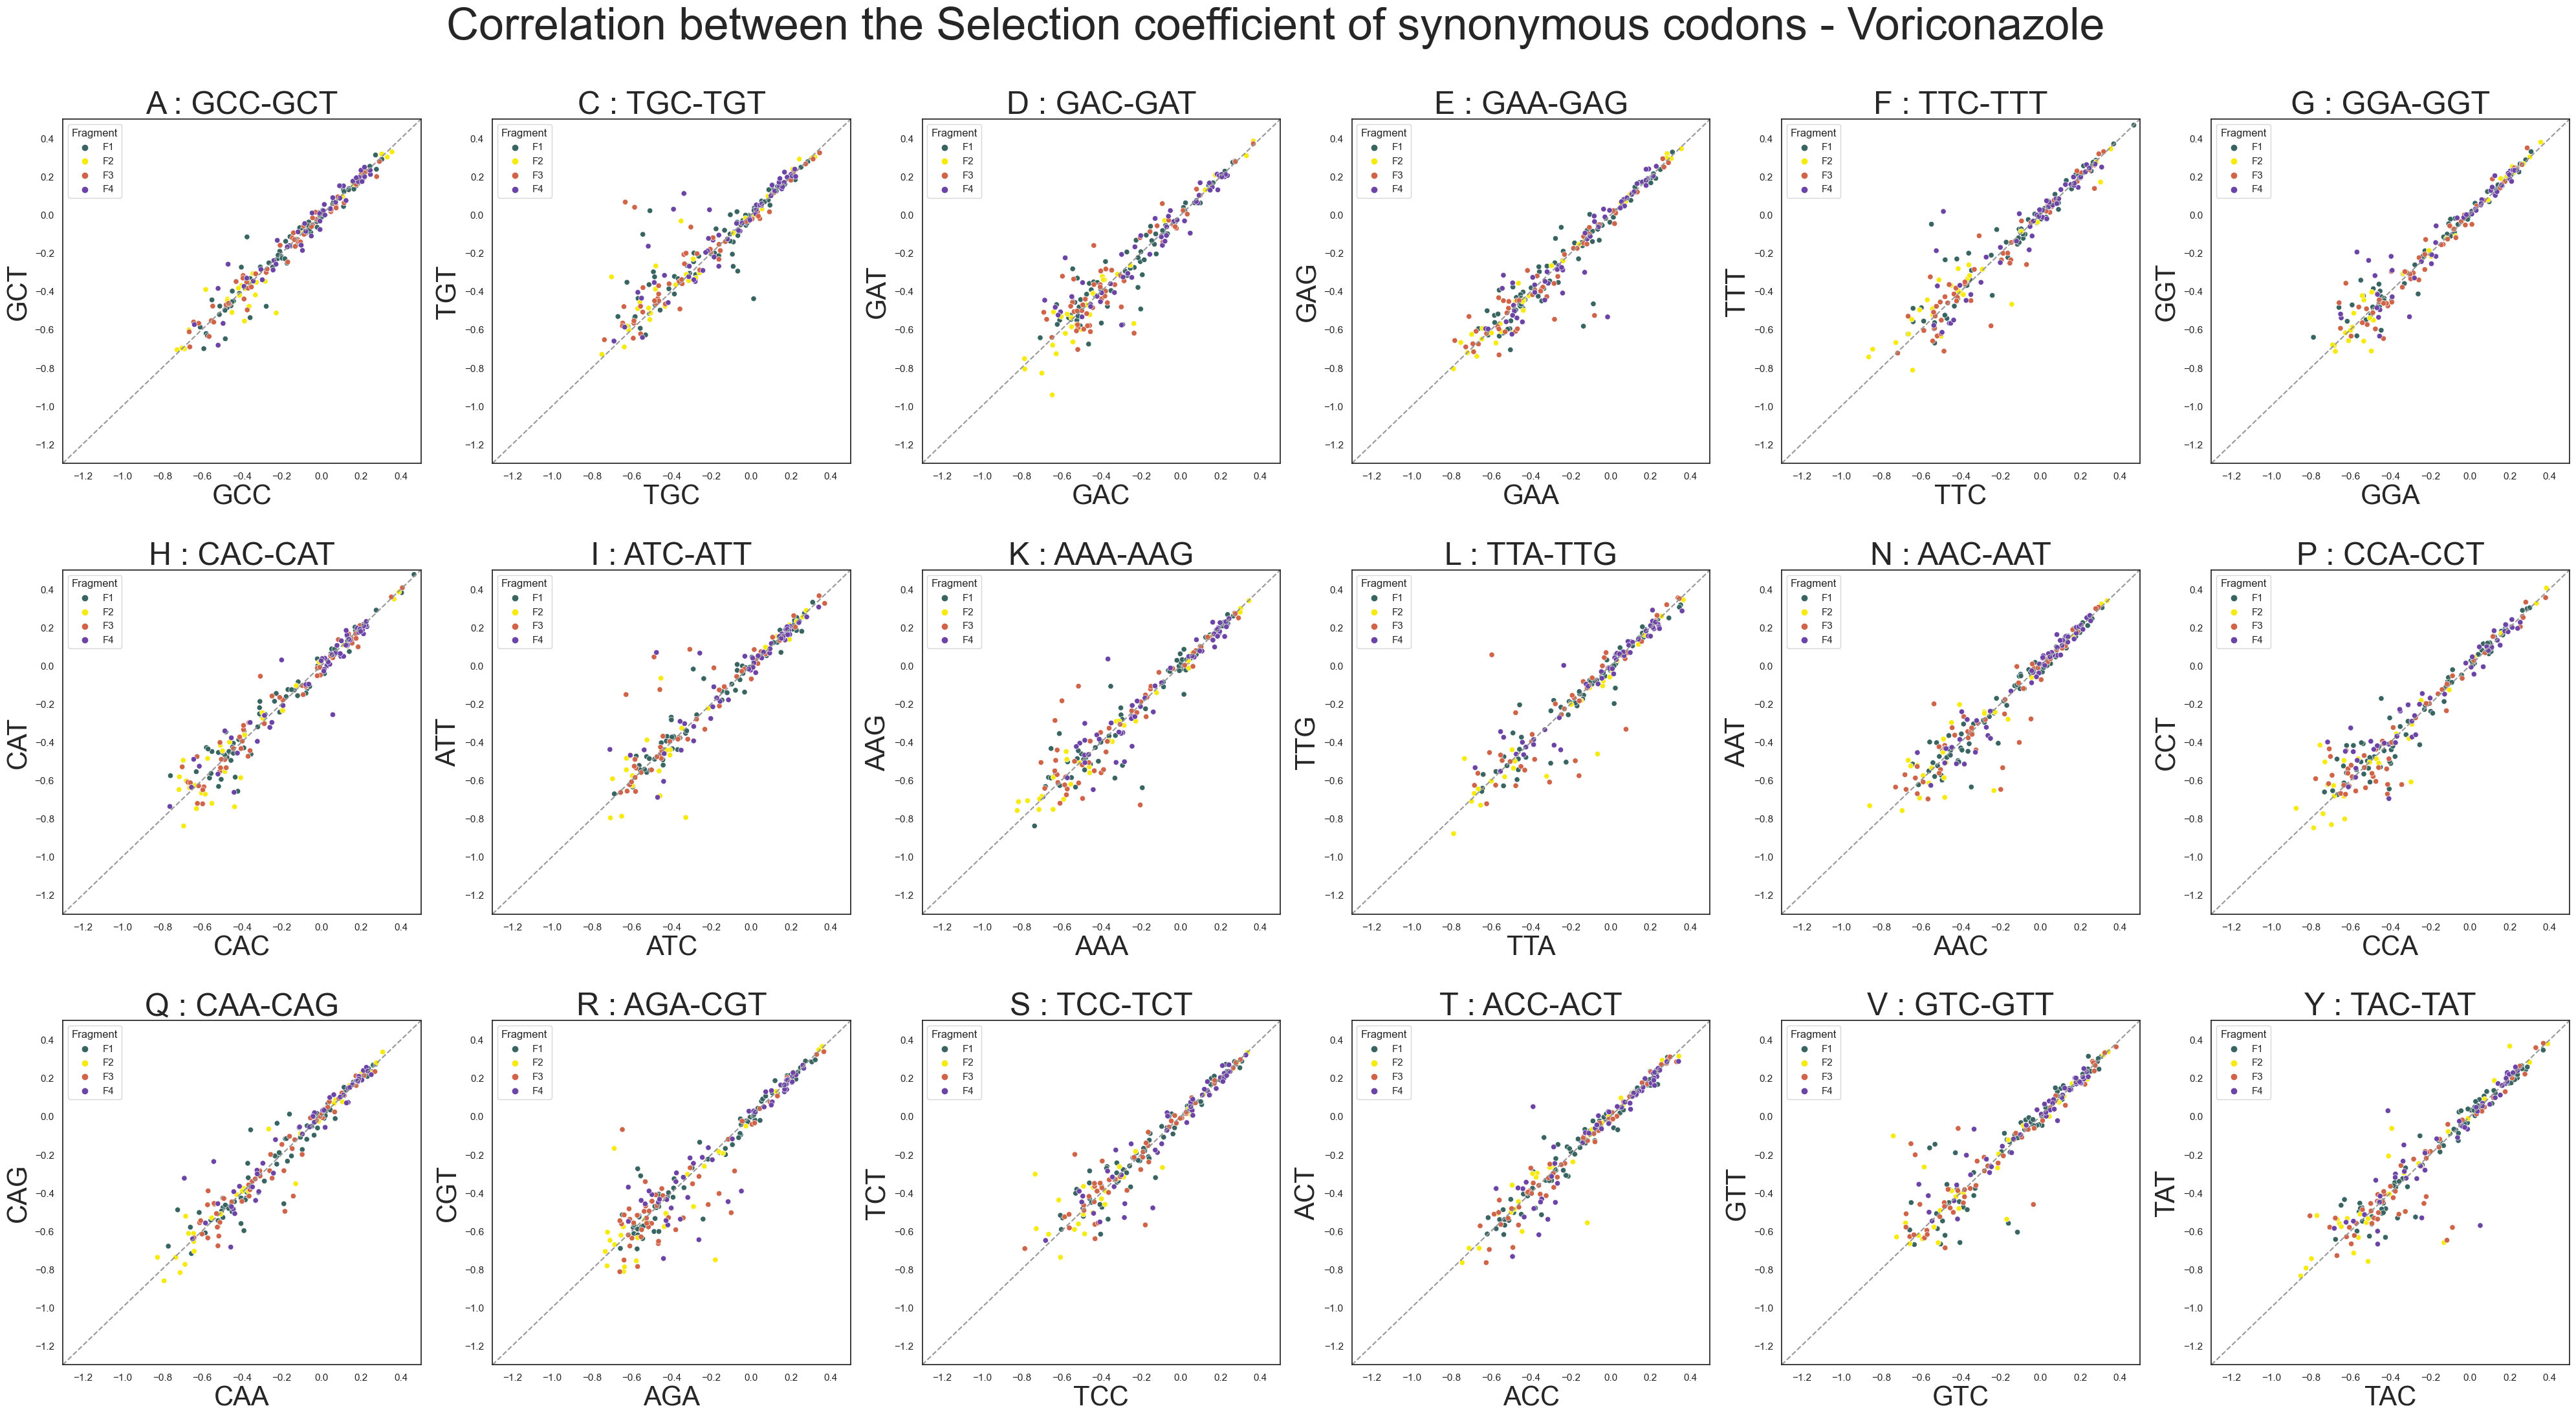

In [41]:
df_co = df_c

# remove wt as they often have only one codon

ite = 0  # Initializing a counter variable

for i in df_co.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_co.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] == aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_co = df_co.drop(ite)  # Dropping the row at index ite
        
    ite = ite + 1  # Incrementing the counter variable

df_cod = df_co.groupby(["codon"])
df_aa = df_co.groupby(["aa"])

syn_list = ["A","C","D","E","F","G","H","I","K","L","N","P","Q","R","S","T","V",'Y']

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(3, 6, figsize=(50,25))
axes = axes.flatten()
    
for aa in syn_list :
    
    sns.set_theme(style="white")
    
    colors = ["#386461","#F6EA0E","#CF6448","#6C44A6"]
    sns.set_palette(sns.color_palette(colors))
    
    amac = df_aa.get_group(aa)
    
    codons = amac['codon'].unique()
    
    cod1 = codons[0]
    cod2 = codons[1]

    cod_df = amac.groupby("codon")
    
    codon1 = cod_df.get_group(cod1).reset_index()
    codon2 = cod_df.get_group(cod2).reset_index()
    
    sns.scatterplot(x = codon1["select_coef"], y = codon2["select_coef"], legend = True, hue = codon1["Fragment"],ax = axes[row])
    axes[row].set_ylabel(cod2, fontsize=30)
    axes[row].set_xlabel(cod1, fontsize=30)
    title = aa + " : " + cod1 + "-" + cod2
    axes[row].set_title(title, fontsize=35)
    axes[row].set_ylim(-1.3, 0.5)
    axes[row].set_xlim(-1.3, 0.5)
    
    x_vals = np.array([-1.3, 0.5])
    y_vals = x_vals

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")

    row +=1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Correlation between the Selection coefficient of synonymous codons - ' + condition, y=0.95, fontsize=50)

name = "Correlation_between_synonymous_codons_" + "select_coeff_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [42]:
# get the mean of every codon

df_group = df_c.groupby(["position","aa","Antifungal","Fragment"])
cols = ["freq_tp0","freq_tp2","l2fc_0_2","nbr_tp0","nbr_tp2","select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal","Fragment"])

name = "Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name)  

# 6 - Control between overlaps

#### We want to verify if the correlation between our overlap is good to see if our results are reproducible and constant.

In [43]:
name ="Selection_coeff_mean_codons_" + condition + "_" + experiment + "_" + date + ".csv"
df_o = pd.read_csv(name, header=0, index_col = 0)

In [44]:
df_o

position aa Antifungal Fragment  freq_tp0  freq_tp2  l2fc_0_2  nbr_tp0  \
0           55  *     Vorico       F1  0.000088  0.000005 -3.995860   341.50   
1           55  A     Vorico       F1  0.000077  0.000055 -0.454942   298.25   
2           55  C     Vorico       F1  0.000089  0.000065 -0.430546   344.25   
3           55  D     Vorico       F1  0.000092  0.000003 -4.938161   356.75   
4           55  E     Vorico       F1  0.000107  0.000007 -4.161944   416.25   
...        ... ..        ...      ...       ...       ...       ...      ...   
4277       511  S     Vorico       F4  0.000127  0.000145  0.858840   520.00   
4278       511  T     Vorico       F4  0.000136  0.000050 -1.140917   555.00   
4279       511  V     Vorico       F4  0.000095  0.000059 -0.391247   387.00   
4280       511  W     Vorico       F4  0.000121  0.000064 -0.879749   493.00   
4281       511  Y     Vorico       F4  0.000122  0.000008 -3.417956   498.50   

      nbr_tp2  select_coef  
0       16.00    -0.436730  
1      165.00    -0.043216  
2      198.00    -0.040488  
3        8.25    -0.539672  
4       18.75    -0.453048  
...       ...          ...  
4277   586.00     0.127045  
4278   183.00    -0.023708  
4279   208.00     0.053851  
4280   259.00     0.018303  
4281    31.00    -0.285859  

[4282 rows x 10 columns]

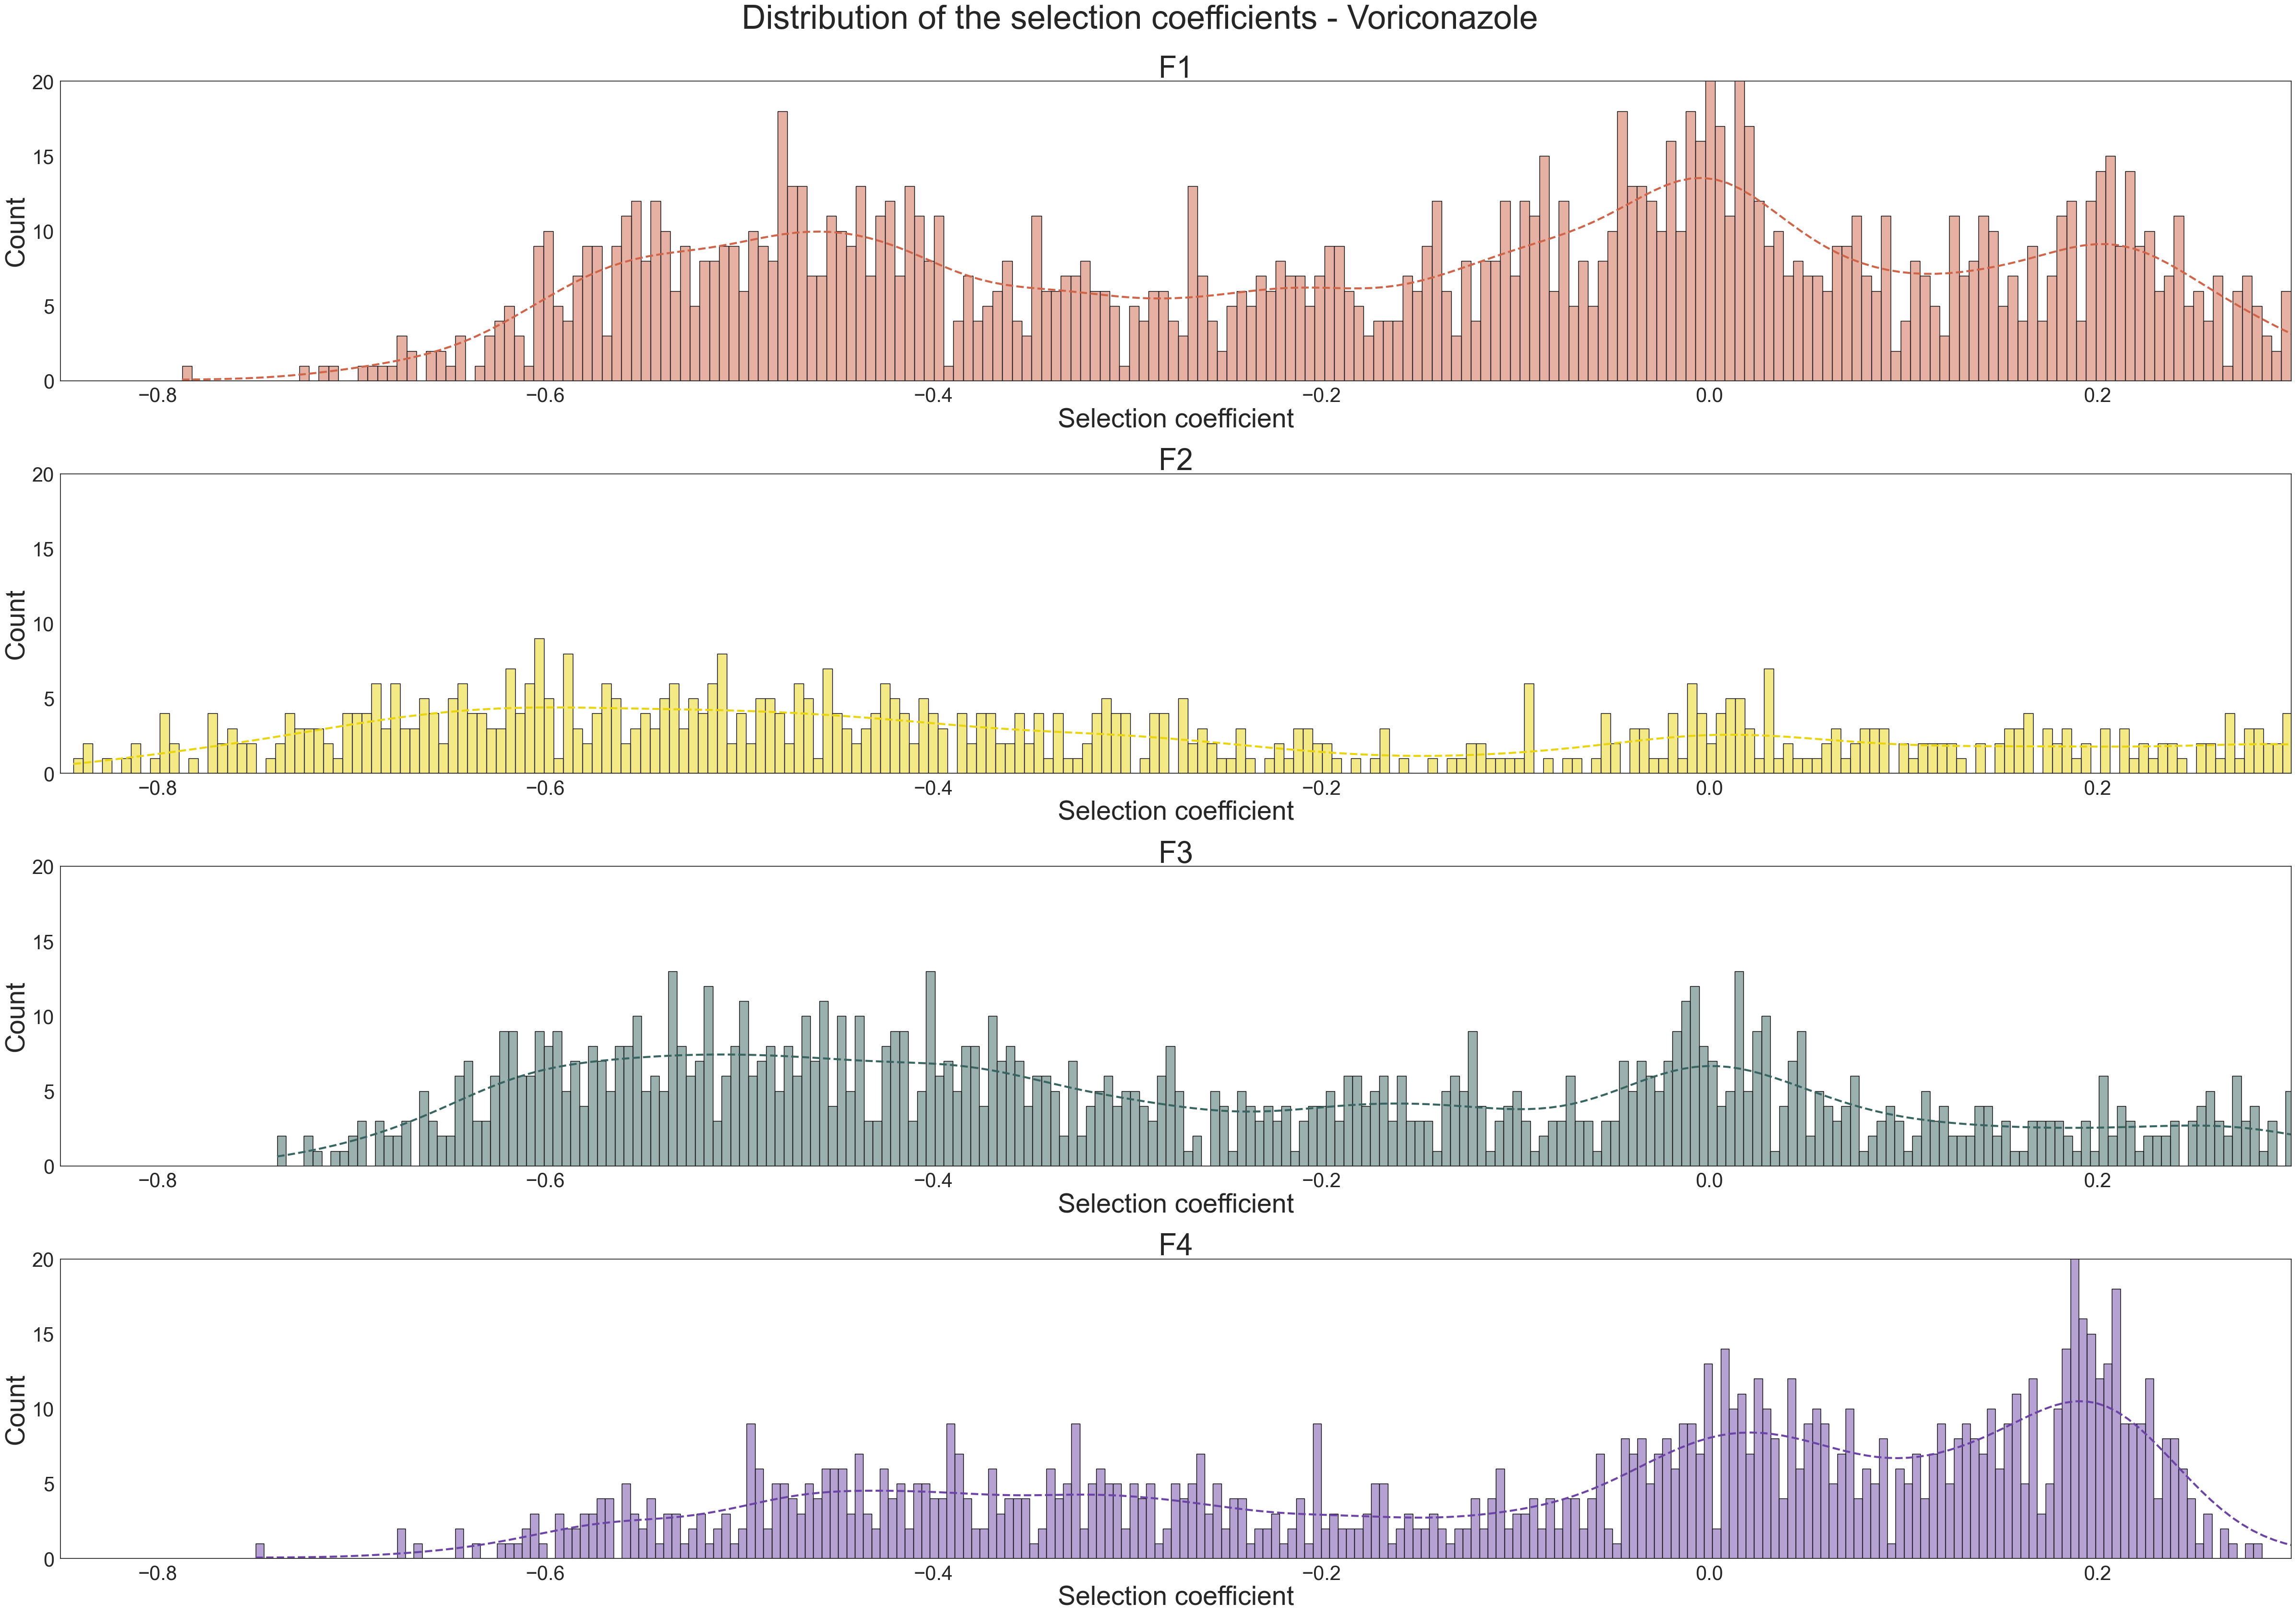

In [45]:
#Distribution of the selection coefficient

df_o_F = df_o.groupby("Fragment")

f_list = ["F1","F2","F3","F4"]
color_list = ["#CF6448","#E9D40D","#386461","#6C44A6"]
row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(4, 1, figsize=(60,40))
axes = axes.flatten()
 
for frag in f_list :
    
    df = df_o_F.get_group(frag)
    
    sns.set_theme(style="white")
    
    sns.histplot(x=df["select_coef"], edgecolor="black", color = color_list[row],  bins = 250,kde=True, kde_kws = {'bw_adjust': 0.5},ax = axes[row], 
                 line_kws = {'linestyle':'dashed','linewidth':'3'}).lines[0].set_color(color_list[row])

    axes[row].set_ylim(0, 20)
    axes[row].set_xlim(-0.85, 0.3)
    
    axes[row].set_ylabel("Count",fontsize=40)
    axes[row].set_xlabel("Selection coefficient",fontsize=40)
    
    axes[row].set_title(frag, fontsize=45)
    
    axes[row].tick_params(labelsize = 30)  
    
    row += 1
    
fig.subplots_adjust(hspace=0.31)
fig.suptitle('Distribution of the selection coefficients - ' + condition, y=0.92, fontsize=50)

name = "Distribution_of_the_selection_coefficient_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

In [46]:
#put rows in overlaps in a new df

df_new = pd.DataFrame(columns=["index", 'position', 'aa', 'Antifungal', 'Fragment', "l2fc_0_2", "l2fc_0_3", "select_coef", "l2fc_0_2_norm", "l2fc_0_3_norm", "select_coef_norm"])

for _, row in df_o.iterrows():
    position = row['position']
    fragment = row['Fragment']
    
    if position in f3_f4_over and fragment == "F3":
        row['Fragment'] = "F3_4"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F2":
        row['Fragment'] = "F2_3"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f2_f3_over and fragment == "F3":
        row['Fragment'] = "F3_2"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in f1_f2_over and fragment == "F2":
        row['Fragment'] = "F2_1"
        df_new = df_new.append(row, ignore_index=True)
        
    elif position in over_list:
        df_new = df_new.append(row, ignore_index=True)
        
df_new = df_new.reset_index().drop("index",axis=1).drop("level_0",axis=1)

C:\Users\CABED117\AppData\Local\Temp\ipykernel_8824\2685448605.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_8824\2685448605.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_8824\2685448605.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_index=True)
C:\Users\CABED117\AppData\Local\Temp\ipykernel_8824\2685448605.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row, ignore_inde

In [47]:
df_group = df_new.groupby(["Fragment"])

f1 = df_group.get_group("F1").reset_index()
f2_1 = df_group.get_group("F2_1").reset_index()
f2_3 = df_group.get_group("F2_3").reset_index()
f3_2 = df_group.get_group("F3_2").reset_index()
f3_4 = df_group.get_group("F3_4").reset_index()
f4 = df_group.get_group("F4").reset_index()

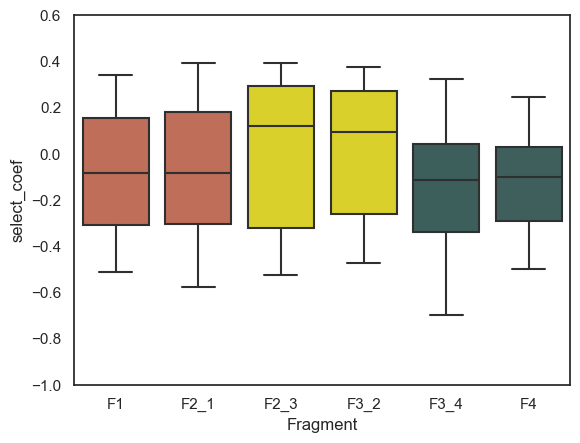

In [48]:
sns.set_theme(style="white")

custom_palette = sns.blend_palette(["#CF6448","#CF6448","#F6EA0E","#F6EA0E","#386461","#386461"], n_colors=6)
sns.boxplot(data= df_new, x= "Fragment", y = "select_coef", palette = custom_palette)
plt.ylim(-1, 0.6)

name = "Boxplot_overlaps_med_select_coef_" + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=400)

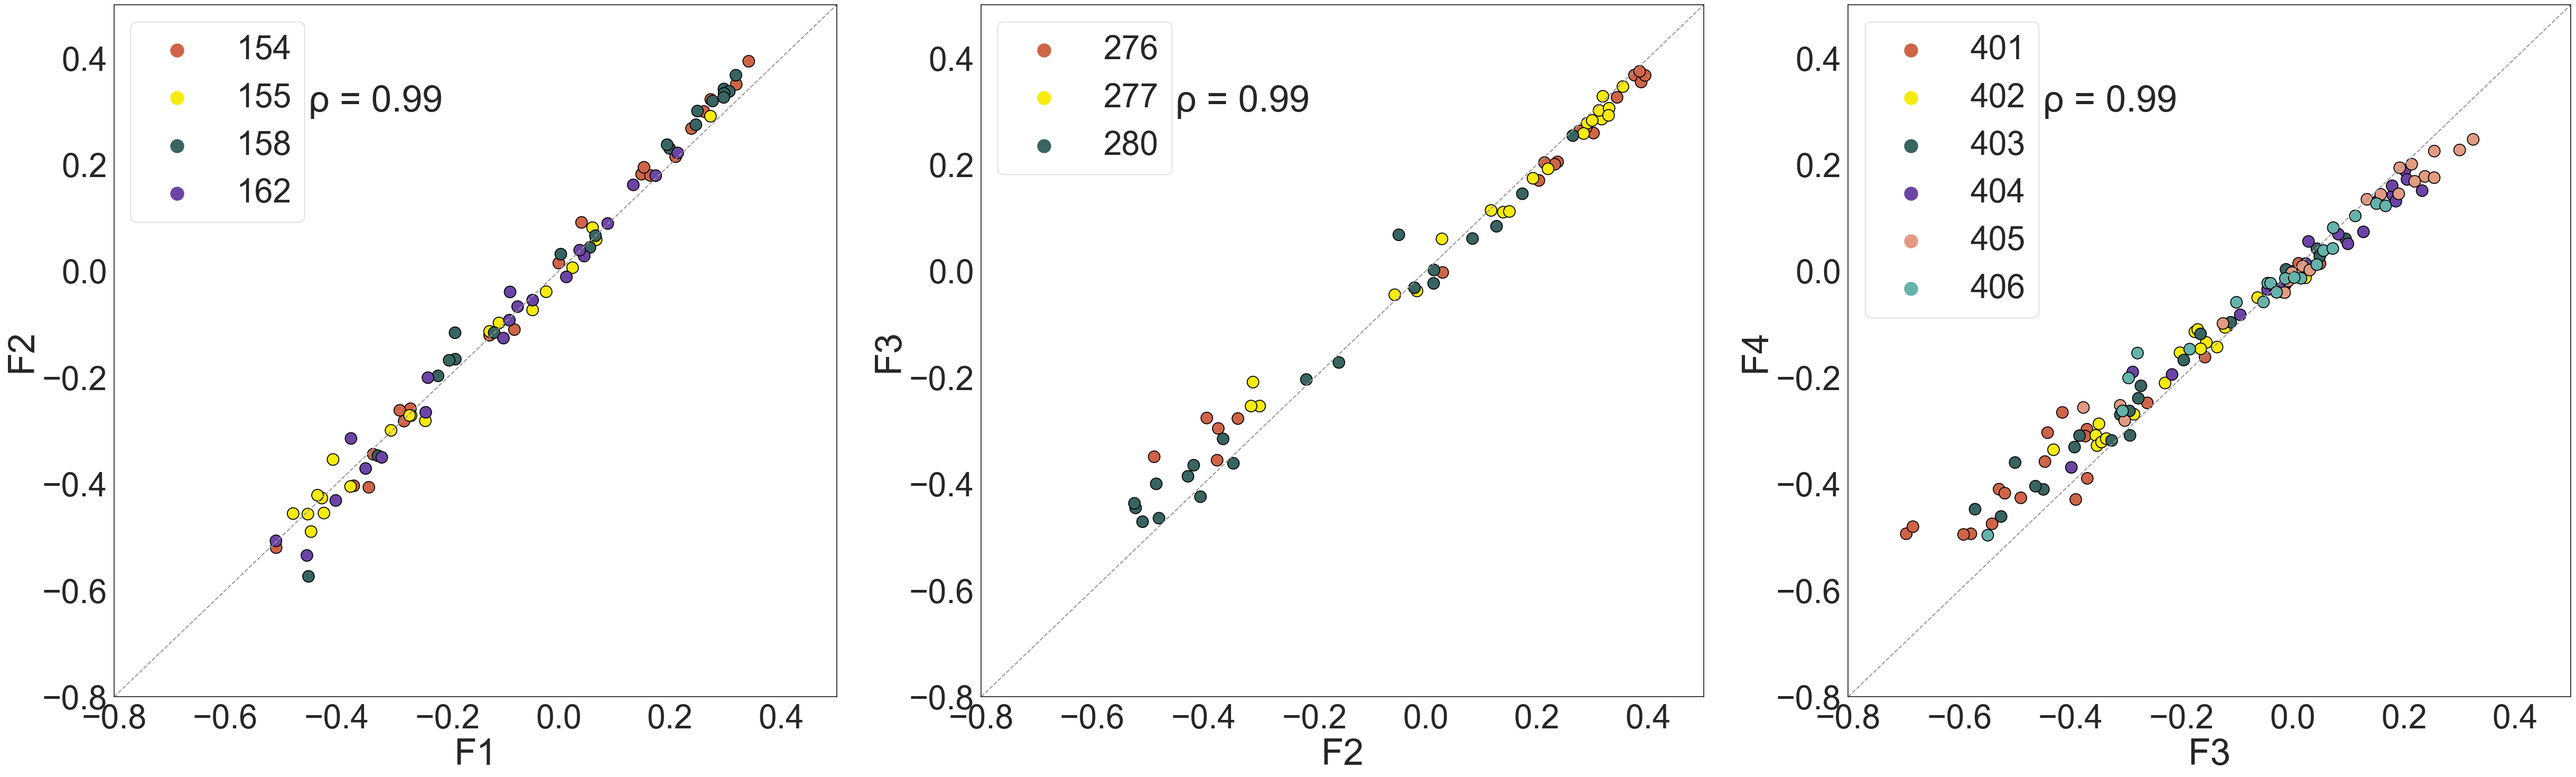

In [49]:
#correlation between replicates

df_r_g = df_r.groupby("Replicate")

o1_list = ["f1","f2_3","f3_4"]

o2_list = ["f2_1","f3_2","f4"]

title_name = ["F1 and F2","F2 and F3","F3 and F4"]
x_name = ["F1", "F2", "F3"]
y_name = ["F2", "F3", "F4"]

row = 0
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(60,17))
axes = axes.flatten()
    
for i in range(len(o1_list)) :
    
    name1 = o1_list[i]
    df1 = globals()[name1]
    
    name2 = o2_list[i]
    df2 = globals()[name2]
    
    sns.set_theme(style="white")
    
    custom_palette = sns.color_palette(["#CF6448","#F6EA0E","#386461","#6C44A6","#E29B82","#64B3AC"], n_colors=len(df1["position"].unique()))
    
    sns.scatterplot(x=df1["select_coef"],  y=df2["select_coef"], legend = True, palette = custom_palette,edgecolor="black",  
                    hue = df1["position"],s = 250, ax = axes[row])    
    
    axes[row].set_ylabel(y_name[i], fontsize=50)
    axes[row].set_xlabel(x_name[i], fontsize=50)
    
    #axes[row].set_title(title_name[i], fontsize=55)
    
    axes[row].set_ylim(-0.8, 0.5)
    axes[row].set_xlim(-0.8, 0.5)
    
    axes[row].tick_params(labelsize = 45)
    
    x_vals = np.array([-0.8, 0.5])
    y_vals = x_vals
    
    result = sp.stats.spearmanr(df1["select_coef"],df2["select_coef"])
    coeff = result[0]
    p_value = result[1]
    R2 = coeff**2 
    
    text = "ρ = " + str(round(coeff, 2)) #+ "\nP = " + str(round(p_value, 5))
    axes[row].text(-0.45,0.3, text , fontsize = 50)

    # Plot the diagonal line
    axes[row].plot(x_vals, y_vals, '--', color="#989898")
    
    # Increase the size of the legend
    axes[row].legend(fontsize=45, markerscale=3)
        
    row +=1
    
fig.subplots_adjust(hspace=0.31)



plt.rcParams['svg.fonttype'] = 'none'
name = "Overlap_select_coef_"  + condition + "_" + experiment + "_" + date 
plt.savefig(f"c:{name}.png", format='png', transparent=True, dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', transparent=True, dpi=300)

In [51]:
#Getting the means of the overlapping positions

#norm_df = norm_df.drop('Fragment', axis=1)

df_group = df_o.groupby(["position","aa","Antifungal"])
cols = ["select_coef"]
df_mean = df_group[cols].mean()

#reset index so the index becomes columns again
df_mean = df_mean.reset_index(level=["position","aa","Antifungal"])

name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_mean.to_csv(name) 

# 7- Heatmaps !!

In [52]:
name = "Select_coeff_mean_overlap_" + condition + "_" + experiment + "_" + date + ".csv"
df_f = pd.read_csv(name, header=0, index_col = 0)

In [53]:
WT_annot = pd.read_excel('../wt_aa_annot.xlsx', header=0, index_col = 0)

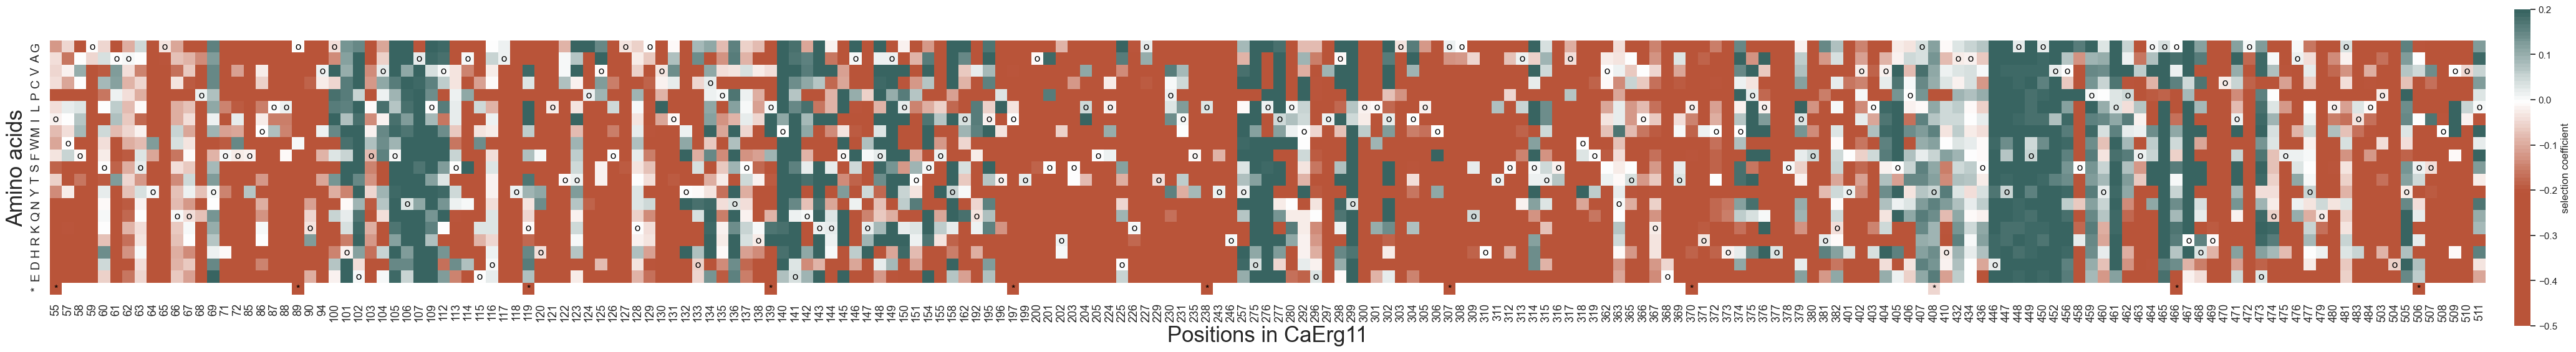

In [54]:
heat = pd.pivot_table(df_f, index="aa", columns= "position", values="select_coef")

heat = heat.reindex(index = ["G","A","V","C","P","L","I","M","W","F","S","T","Y","N","Q","K","R","H","D","E","*"])

custom_palette = sns.blend_palette(["#B95439","#B95439","#B95439","#FFFFFF","#386461"], n_colors=101)

plt.subplots(figsize=(60,60))
sns.set(rc={'figure.facecolor':'white'})
#sns.set(font_scale=1.5)

sns.heatmap(heat, xticklabels="auto", yticklabels=True, annot=False, cmap = custom_palette, 
            robust = True,square=True,  vmin=-0.5, vmax=0.2,center=-0.2, 
            cbar_kws={"shrink": 0.11,"pad": 0.01,'label': 'selection coefficient'})

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=13)

for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        if WT_annot.iloc[i, j] == "o" or WT_annot.iloc[i, j] == "*":
            plt.text(j + 0.5, i + 0.5, WT_annot.iloc[i, j], ha='center', va='center', fontsize=12, color='black')
        
#titre = f"Selection coefficients - {condition} Screening - Library Erg11 of " + '$\it{Candida}$' +" "+ '$\it{albicans}$'

#plt.title(titre, fontsize =30)

plt.xlabel('Positions in CaErg11', fontsize = 25)
plt.ylabel('Amino acids', fontsize = 25)

plt.rcParams['svg.fonttype'] = 'none'
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".png"
plt.savefig(name, transparent=True, dpi=750,format='png', bbox_inches='tight')
name = "Heatmap_" + "select_coef_" + condition + "_" +experiment + "_" + date + ".svg"
plt.savefig(name, transparent=True, dpi=300,format='svg', bbox_inches='tight')

# 9- t-test significant resistance

In [55]:
#import the df with the replicates, replicates are needed for t tests
name = "Select_coeff_log2foldchange_" + condition + "_" + experiment + "_" + date + ".csv"

df_t = pd.read_csv(name, header=0)

In [56]:
# Add a new column with the translation
df_t['aa'] = df_t['codon'].map(DNA_Codons)
df_t['DNA_variant'] =df_t['position'].astype(str) + df_t['codon']
df_t['aa_variant'] =df_t['position'].astype(str) + df_t['aa']

In [57]:
Ca_ERG11 = "ATGGCCATTGTTGAAACGGTAATAGATGGAATCAACTATTTTTTATCACTGTCTGTAACTCAACAAATTAGTATATTACTAGGGGTCCCGTTTGTGTACAATCTGGTTTGGCAGTATTTATATAGTCTAAGAAAAGATAGAGCACCCCTGGTATTCTATTGGATACCCTGGTTCGGCTCAGCAGCGTCTTATGGTCAACAACCGTATGAATTTTTTGAGTCATGCAGGCAGAAATATGGCGATGTTTTTTCCTTTATGCTTCTTGGGAAAATAATGACTGTGTACCTTGGCCCAAAGGGTCACGAATTTGTCTTCAATGCGAAGTTAAGCGATGTCTCTGCTGAAGATGCATACAAACACTTAACAACTCCGGTATTCGGAAAGGGAGTTATCTACGATTGTCCCAACAGTCGTCTGATGGAGCAGAAAAAGTTTGCTAAATTCGCGCTTACTACGGACTCATTCAAAAGGTATGTACCCAAAATTCGTGAAGAAATATTAAACTATTTCGTAACAGACGAAAGTTTCAAATTAAAGGAAAAGACACACGGCGTGGCTAACGTGATGAAAACACAACCTGAAATCACCATTTTTACCGCCAGCAGGTCCTTATTTGGCGACGAGATGAGAAGAATTTTCGATAGAAGTTTTGCTCAACTGTACTCAGATTTGGATAAAGGTTTTACTCCGATAAATTTCGTGTTCCCAAACCTTCCTTTGCCACACTATTGGAGAAGAGATGCTGCACAAAAGAAGATAAGTGCGACCTATATGAAAGAGATAAAATCCCGTAGGGAAAGGGGTGACATTGACCCTAACAGAGACTTGATTGATTCTCTGCTGATTCATAGCACATACAAAGACGGTGTGAAGATGACCGACCAGGAGATTGCAAACCTGCTTATAGGTATTTTAATGGGTGGACAGCACACATCAGCTTCTACGTCAGCATGGTTTCTGCTACACCTGGGGGAAAAACCGCACCTACAAGACGTAATATATCAAGAGGTGGTGGAGTTACTAAAAGAGAAAGGAGGCGATCTAAACGATTTAACCTATGAGGATCTGCAAAAATTGCCGTCAGTCAACAACACGATCAAGGAAACGCTAAGGATGCACATGCCTCTACACAGTATATTCAGAAAAGTTACTAACCCACTTAGGATCCCTGAAACCAACTACATCGTCCCAAAAGGACACTACGTTCTTGTCAGCCCAGGCTACGCACACACGAGTGAGAGATACTTTGATAACCCGGAGGATTTTGATCCTACACGTTGGGATACTGCTGCAGCCAAAGCCAATTCTGTAAGCTTTAACTCCAGTGATGAGGTAGATTACGGCTTTGGGAAAGTATCAAAAGGCGTCAGCTCACCATATCTTCCCTTCGGTGGCGGTAGACATAGATGTATAGGTGAACAATTTGCATACGTTCAGCTGGGAACCATATTAACGACGTTTGTTTATAACTTGAGATGGACTATCGACGGGTATAAAGTCCCTGATCCTGACTATAGCTCTATGGTTGTTctaCCCACCGAACCGGCTGAAATAATTTGGGAGAAAAGAGAGACATGTATGTTTTGA"

#Get the codons in the wt seq

wt_dict = {}
pos = 1

for i in range(0, len(Ca_ERG11), 3):
    codon = Ca_ERG11[i:i + 3]
    wt_dict.update({pos : codon})
    pos = pos+1

In [58]:
# get all the wts infos in our df fluco

df_wt = df_t  # Assigning merged_df to df_wt

ite = 0  # Initializing a counter variable

for i in df_wt.iterrows():  # Iterating over the rows of df_wt
    
    first_row = df_wt.loc[ite]  # Accessing the row at index ite
    
    position = first_row['position']  # Extracting the value of 'position' column
    aa_wt = aa_dict[position]  # Getting the corresponding value from wt_dict
    
    if first_row['aa'] != aa_wt:  # Comparing 'codon' value with codon_wt
        
        df_wt = df_wt.drop(ite)  # Dropping the row at index ite
        
    else :   
        df_t.loc[ite,"aa_variant"] = "WT"
        
    ite = ite + 1  # Incrementing the counter variable
    
df_wt = df_wt.drop("level_0",axis=1).reset_index()

In [59]:
# Perform t-tests for each variant
variants = df_t['aa_variant'].unique()
results = []

for variant in variants:
    variant_data = df_t[df_t['aa_variant'] == variant]

    anti_data = variant_data[variant_data['Antifungal'] == cond]['select_coef']
    wt_data = df_t[df_t['aa_variant'] == 'WT']['select_coef']
    t_stat, p_value = ttest_ind(anti_data, wt_data)
    
    results.append((variant, p_value))

# Apply FDR correction to the p-values decause I am doing multiple comparaison
_, adjusted_p_values, _, _ = multipletests([p_value for _, p_value in results], method='fdr_bh')

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['aa_variant', 'p_value'])
results_df['adjusted_p_value'] = adjusted_p_values

# View the results
print(results_df)

     aa_variant        p_value  adjusted_p_value
0           55K  1.832126e-111     5.701768e-111
1           55N   9.026520e-74      2.057144e-73
2           55T   6.614052e-04      7.507684e-04
3           55R  3.578954e-115     1.160963e-114
4            WT   1.000000e+00      1.000000e+00
...         ...            ...               ...
3826       511Y   1.538184e-75      3.552009e-75
3827       511S   1.496693e-24      2.180994e-24
3828       511C   3.350225e-15      4.448774e-15
3829       511W   8.507766e-01      8.559152e-01
3830       511F   7.011251e-87      1.739644e-86

[3831 rows x 3 columns]


In [60]:
# Merge the variant results 
anti_merged = df_t.merge(results_df, on=['aa_variant'], how='left')

In [61]:
df_group = anti_merged.groupby(["position","Antifungal","aa"])
cols = ["select_coef","p_value","adjusted_p_value"]
med_anti = df_group[cols].median()

#reset index so the index becomes columns again
med_anti = med_anti.reset_index(level=["position","Antifungal","aa"])
med_anti['aa_variant'] =med_anti['position'].astype(str) + med_anti['aa']

In [62]:
advantageous = []
wt_like = []
deleterious = []
df_del = pd.DataFrame(columns=['select_coef', 'aa_variant', 'result'])

for i in range(len(med_anti)):
    if med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] > 0:
        advantageous.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Advantageous"
    elif med_anti.loc[i,"adjusted_p_value"] > 0.01 :
        wt_like.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "WT like"
    elif med_anti.loc[i,"adjusted_p_value"] < 0.01 and med_anti.loc[i,"select_coef"] < 0:
        deleterious.append(med_anti.loc[i, "aa_variant"])
        df_del.loc[i,"select_coef"] = med_anti.loc[i,"select_coef"]
        df_del.loc[i,"aa_variant"] = med_anti.loc[i,"aa_variant"]
        df_del.loc[i,"result"] = "Deleterious"

In [63]:
print(str(len(advantageous)) + " variant have an advantage")
print(str(len(deleterious)) + " variant have a deleterious substitution")
print(str(len(wt_like)) + " variant are like the WT without antifungal")

1044 variant have an advantage
2433 variant have a deleterious substitution
545 variant are like the WT without antifungal


In [64]:
df_del_g = df_del.groupby("result")
df_del_wt = df_del_g.get_group("WT like")
#df_del_wt["select_coef"].max()
#df_del_wt["select_coef"].min()
df_del_wt["select_coef"].quantile(0.05)
#df_del_wt["select_coef"].quantile(0.05)

-0.03999529749815922

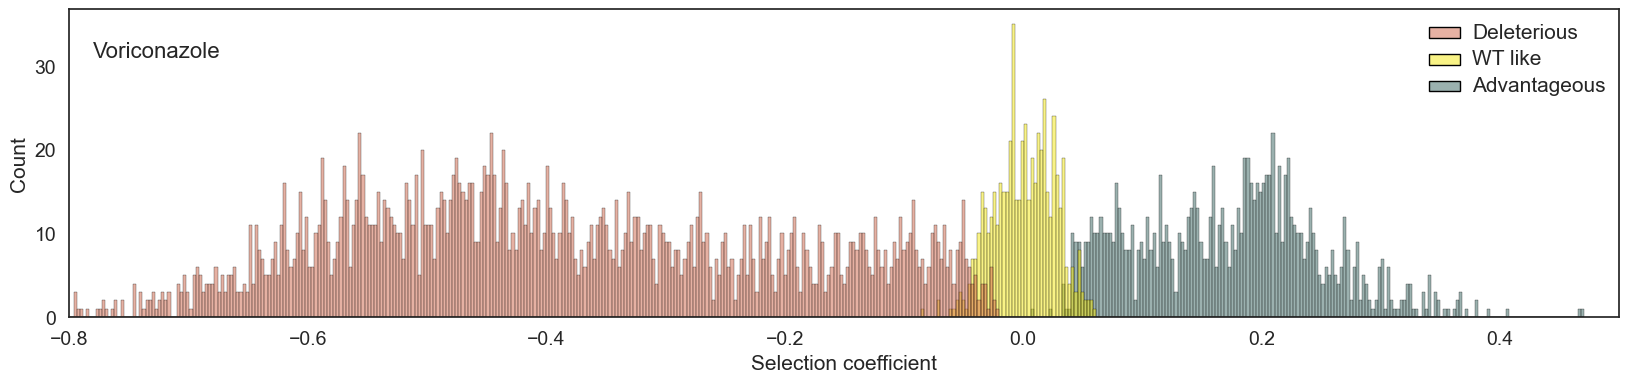

In [65]:
sns.set_style("white")
sns.set_theme(style="white", palette=None)

plt.subplots(figsize=(20, 4))
custom_palette = sns.blend_palette(["#CF6448", "#F6EA0E", "#386461"], n_colors=3)

plot = sns.histplot(data=df_del, x="select_coef", edgecolor="black", hue="result", palette=custom_palette, bins=500)

legend = plot.get_legend()  
legend.set_title("", prop={"size": 16} ) 
legend.set_frame_on(False)
for label in legend.get_texts():  
    label.set_size(15)  
    
plt.xlim(-0.8, 0.5)
#plt.title(condition + " - distribution of the selection coefficient", fontsize=20)

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)

plt.xlabel('Selection coefficient', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

plt.text(-0.78,31, condition , fontsize = 16)
    
plt.rcParams['svg.fonttype'] = 'none'
name = "Distribution_" + "select_coef_t-test_results_" + condition + "_" +experiment + "_" + date 
plt.savefig(name+ ".png", transparent=True, dpi=750,format='png', bbox_inches='tight')
plt.savefig(name+ ".svg", transparent=True, dpi=750,format='svg', bbox_inches='tight')

In [66]:
#med_anti = med_anti.drop(["level_0","index"], axis=1)
med_anti = med_anti.rename(columns={"aa_variant": "variant"})
name = "Select_coeff_p_value_aa_" + condition + "_" + experiment + "_" + date + ".csv"
med_anti.to_csv(name) 

med_anti

position Antifungal aa  select_coef        p_value  adjusted_p_value  \
0           55     Vorico  *    -0.436730   5.462745e-61      1.119132e-60   
1           55     Vorico  A    -0.033326   7.920960e-03      8.742495e-03   
2           55     Vorico  C    -0.030449   1.249537e-02      1.370056e-02   
3           55     Vorico  D    -0.545815  4.666976e-140     2.115880e-139   
4           55     Vorico  E    -0.432500  1.453919e-109     4.459539e-109   
...        ...        ... ..          ...            ...               ...   
4017       511     Vorico  S     0.127737   1.496693e-24      2.180994e-24   
4018       511     Vorico  T    -0.024916   8.196571e-02      8.746814e-02   
4019       511     Vorico  V     0.059025   7.263002e-04      8.234555e-04   
4020       511     Vorico  W     0.018303   8.507766e-01      8.559152e-01   
4021       511     Vorico  Y    -0.297043   1.538184e-75      3.552009e-75   

     variant  
0        55*  
1        55A  
2        55C  
3        55D  
4        55E  
...      ...  
4017    511S  
4018    511T  
4019    511V  
4020    511W  
4021    511Y  

[4022 rows x 7 columns]